In [96]:
from drought.visualization import plot
from drought.data import pipeline
import matplotlib.pyplot as plt
import pandas as pd
from drought.data.aggregator import get_monthly_means_and_shot_count
import drought.data.df_extensions as dfext
import drought.data.interpolate as interpolate
import seaborn as sns
from scipy.stats import norm
import numpy as np
from scipy.optimize import curve_fit
from math import exp

### Get all GEDI Footprints for 8 polygons

In [2]:
footprints = pipeline.get_gedi_footprints()

### GEDI Availability

In [3]:
monthly = get_monthly_means_and_shot_count(footprints, columns=['pai', 'rh100'])

In [4]:
monthly = interpolate.fill_timeseries_missing_data(monthly, 
                                                   start_date='04-2019', 
                                                   end_date='07-2022', 
                                                   values_to_fill={'number': 0})

The resulting df needs to be sorted by year and month so that the x axis of the chart will show months in the correct order. Additionally, year and month columns are converted to proper datetime objects. 

In [5]:
monthly= dfext.add_date_column(monthly)

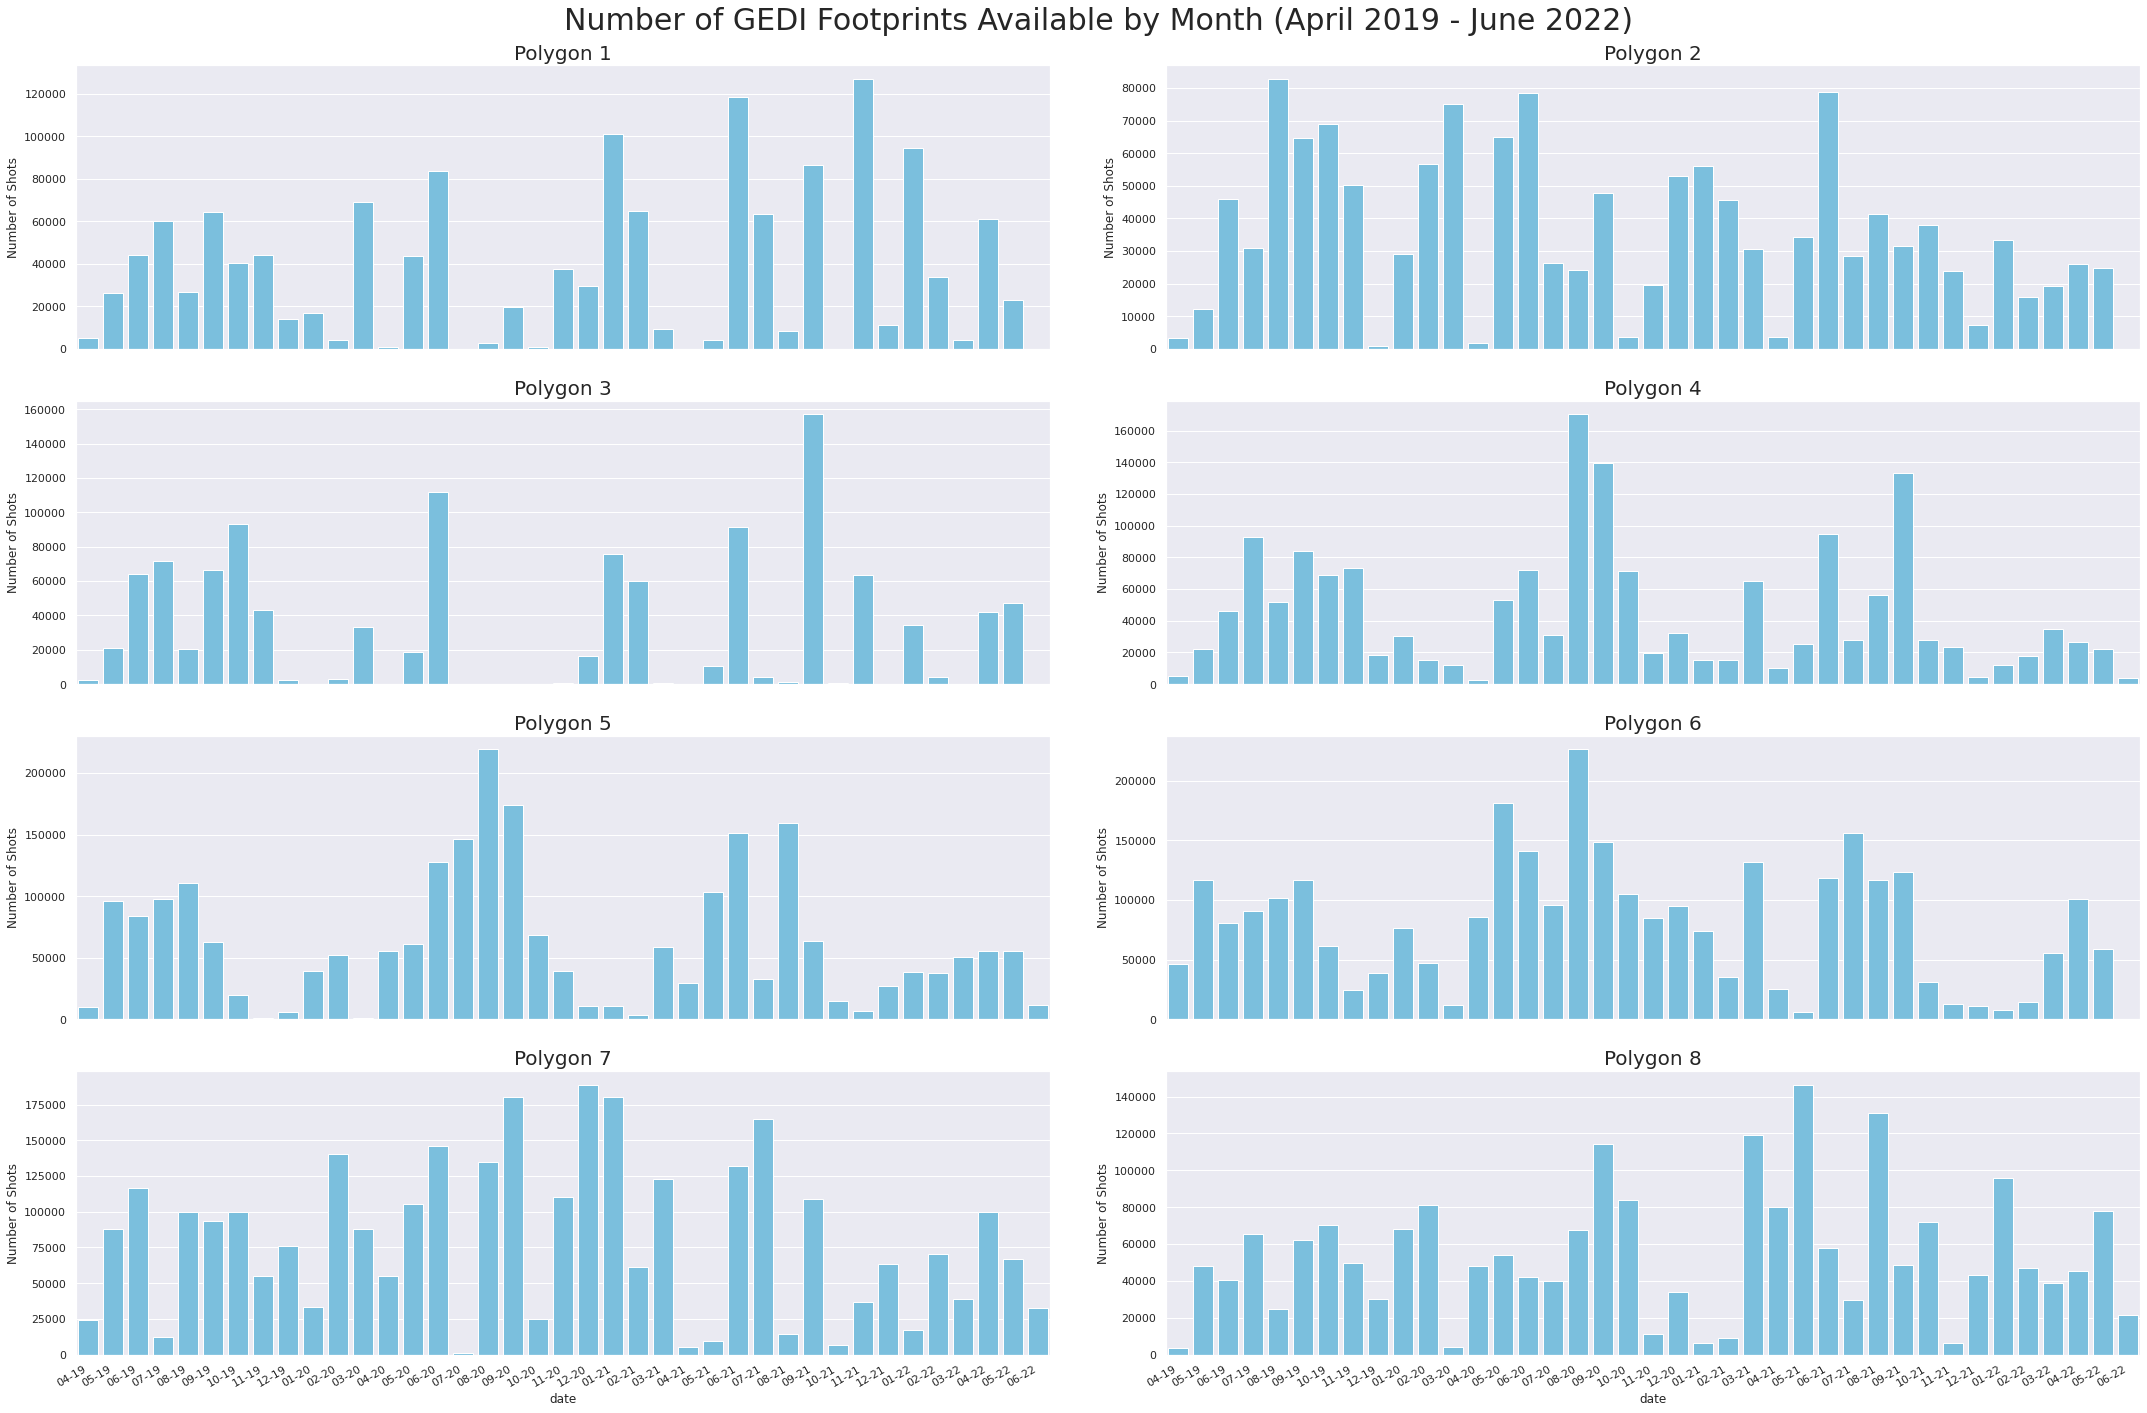

In [6]:
fig, ax = plot.barplot_per_polygon(monthly, 
                                   x='date',
                                   y='number',
                                   ylabel ='Number of Shots',
                                   title="Number of GEDI Footprints Available by Month (April 2019 - June 2022)") # noqa: E501

fig.autofmt_xdate()

In the plot below, we plot the number of GEDI shots for that month vs. the mean PAI value for the month. If there are no GEDI shots for the entire month, we will have missing PAI data. We can see in the plot the missing data where the orange line has the breaks in.

Polygon 3 misses a lot of months in 2020, and Polygon 1 is missing 2 months in total. The rest of the polygons have non-zero shots for each month.

We can note as well that value of PAI in some months is out of line with the PAI values in the adjacent months. These usually correlate with months in which we have fewer GEDI shots. Some obvious outliers are:
* Polygon 1
  *  10-2020
* Polygon 2
  * 04-2019
  * 12-2019
  * 04-2020
* Polygon 3 - many, and much data is missing
* Polygon 4
  * 04-2020
  * 06-2022
* Polygon 5
  * 11-2019
  * 03-2020
* Polygon 6
  * 06-2022
* Polygon 7
  * 07-2020
  * 05-2021
* Polygon 8
  * 03-2020
  * 01-2021
  

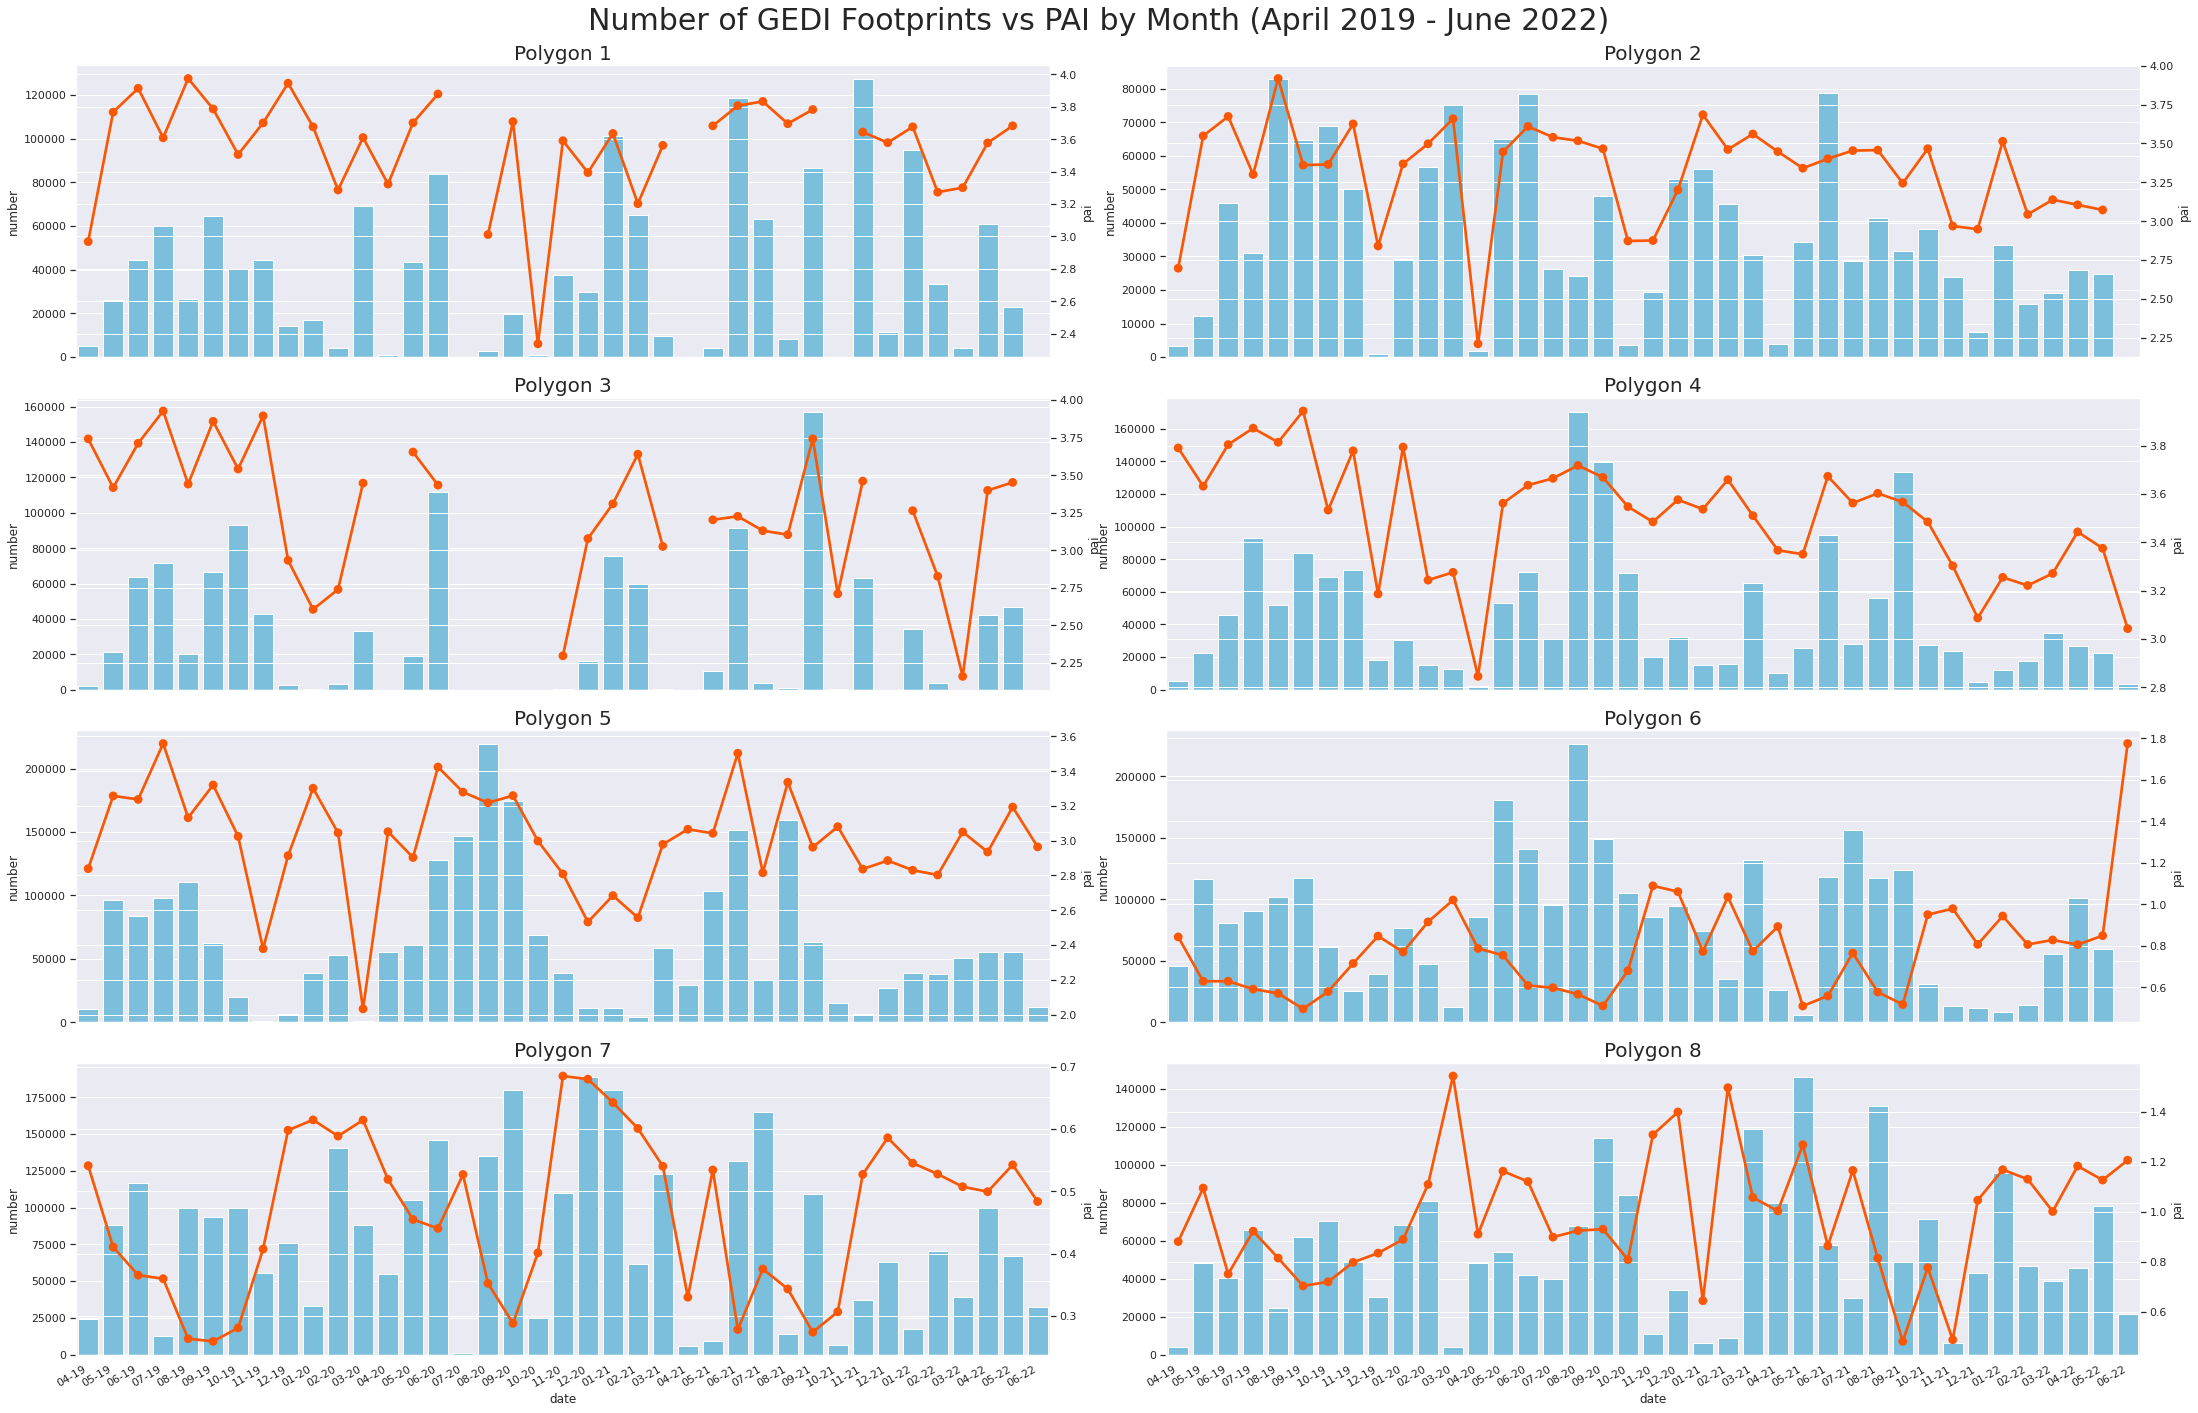

In [7]:
fig, ax = plot.layered_plot_per_polygon(monthly, 
                                        x='date',
                                        bar_y='number',
                                        line_y='pai',
                                        title="Number of GEDI Footprints vs PAI by Month (April 2019 - June 2022)") # noqa: E501

fig.autofmt_xdate()

### Fit GEDI data

### Polygon 1

In [97]:
def fit_function(x, A, beta, B, mu, sigma):
    return (A * np.exp(-x/beta) + B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

In [117]:
def fit_gauss(x, B, mu, sigma):
    return B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))

In [98]:
def get_one_month_data(df, polygon_id, month, year):
    return df.loc[(df.polygon_id == polygon_id)&(df.month==month)&(df.year==year)]

In [139]:
def fit_gaussian_and_plot(df, polygon_id, month, year):
    one_month_data = get_one_month_data(df, polygon_id, month, year).pai
    if (one_month_data.shape[0] == 0):
        print(f'No data for {month} and {year}')
        return
    
    print("Before: " + str(one_month_data.mean()))
    bins = np.linspace(0, 10, 100)
    data_entries, bins = np.histogram(one_month_data, bins=bins)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    mu, std = norm.fit(one_month_data)
    #popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[20000, 2.0, 2000, 3.0, 0.3])
    print("After: " + str(mu))

    # Plot the histogram.
    plt.hist(one_month_data, bins=100, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()

In [182]:
def fit_exponential_gaussian_and_plot(df, polygon_id, month, year, plot=False):
    one_month_data = get_one_month_data(df, polygon_id, month, year).pai
    if (one_month_data.shape[0] == 0):
        #print(f'No data for {month} and {year}')
        return
    
    #print("Before: " + str(one_month_data.mean()))
    bins = np.linspace(0, 10, 200)
    data_entries, bins = np.histogram(one_month_data, bins=bins)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    try:
        popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[100, 2.0, 500, 4.0, 0.3])
        #print("After: " + str(popt[3]))
    except:
        print(f'{polygon_id} {month} {year}')
        print('Could not fit the month!')
        return None

    if not plot:
        return popt[3]
    # plot
    xspace = np.linspace(0, 10, 100000)

    # Plot the histogram and the fitted function.
    plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
    plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')

    # Make the plot nicer.
    plt.xlim(0,10)
    plt.xlabel(r'x axis')
    plt.ylabel(r'Number of entries')
    plt.title(r'Exponential decay with gaussian peak')
    plt.legend(loc='best')
    plt.show()
    plt.clf()
    return popt[3]

In [183]:
new_data = {}

In [218]:
new_data['3_3_2022'] = [3, 2022, 3, get_one_month_data(footprints, 3, 3, 2022).pai.mean()]

In [184]:
# Plot all months for a given year and a given polygon
for polygon_id in range(1, 6):
    for year in range(2019, 2023):
        for month in range(1, 13):
            pai = fit_exponential_gaussian_and_plot(footprints, polygon_id, month, year)
            if pai is not None:
                new_data[f'{polygon_id}_{month}_{year}'] = [polygon_id, year, month, pai]

3 1 2020
Could not fit the month!


In [219]:
# Plot all months for a given year and a given polygon
for polygon_id in range(6, 9):
    for year in range(2019, 2023):
        for month in range(1, 13):
            new_data[f'{polygon_id}_{month}_{year}'] = [polygon_id, year, month, get_one_month_data(footprints, polygon_id, month, year).pai.mean()]

In [220]:
monthly = pd.DataFrame.from_dict(new_data, orient='index', columns=['polygon_id', 'year', 'month', 'pai'])

In [221]:
monthly

polygon_id  year  month       pai
1_4_2019            1  2019      4  3.091650
1_5_2019            1  2019      5  4.191092
1_6_2019            1  2019      6  4.266439
1_7_2019            1  2019      7  4.078947
1_8_2019            1  2019      8  4.373359
...               ...   ...    ...       ...
8_8_2022            8  2022      8       NaN
8_9_2022            8  2022      9       NaN
8_10_2022           8  2022     10       NaN
8_11_2022           8  2022     11       NaN
8_12_2022           8  2022     12       NaN

[326 rows x 4 columns]

In [222]:
import drought.data.df_extensions as dfext
monthly = dfext.add_date_column(monthly)
monthly

polygon_id  year  month  pai   date
6_1_2019            6  2019      1  NaN  01-19
7_1_2019            7  2019      1  NaN  01-19
8_1_2019            8  2019      1  NaN  01-19
6_2_2019            6  2019      2  NaN  02-19
7_2_2019            7  2019      2  NaN  02-19
...               ...   ...    ...  ...    ...
7_11_2022           7  2022     11  NaN  11-22
8_11_2022           8  2022     11  NaN  11-22
6_12_2022           6  2022     12  NaN  12-22
7_12_2022           7  2022     12  NaN  12-22
8_12_2022           8  2022     12  NaN  12-22

[326 rows x 5 columns]

In [ ]:
monthly.to_csv('../../data/interim/gedi_PAI_fitted_monthly.csv')

In [214]:
list_of_outliers = [(1, 10, 2020), (2, 4, 2019), (2, 12, 2019), (2, 4, 2020), (2, 10, 2020), (2, 11, 2020), (3, 12, 2019), (3, 11, 2020), (3, 3, 2022), (4, 10, 2019), (4, 12, 2019), (4, 4, 2020), (4, 4, 2021), (4, 6, 2022), (5, 11, 2019), (5, 3, 2020)]

1 10 2020


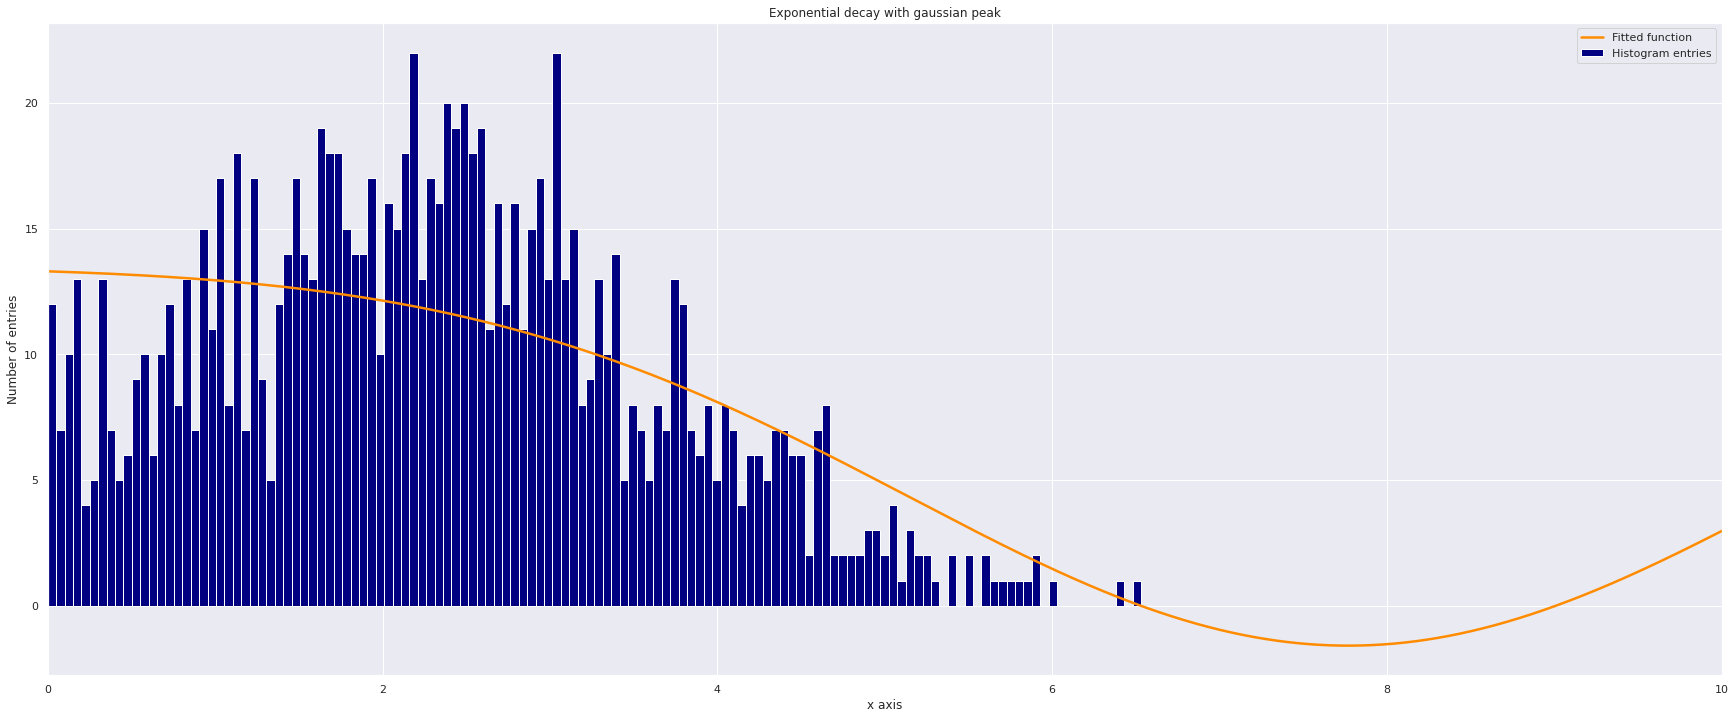

2 4 2019


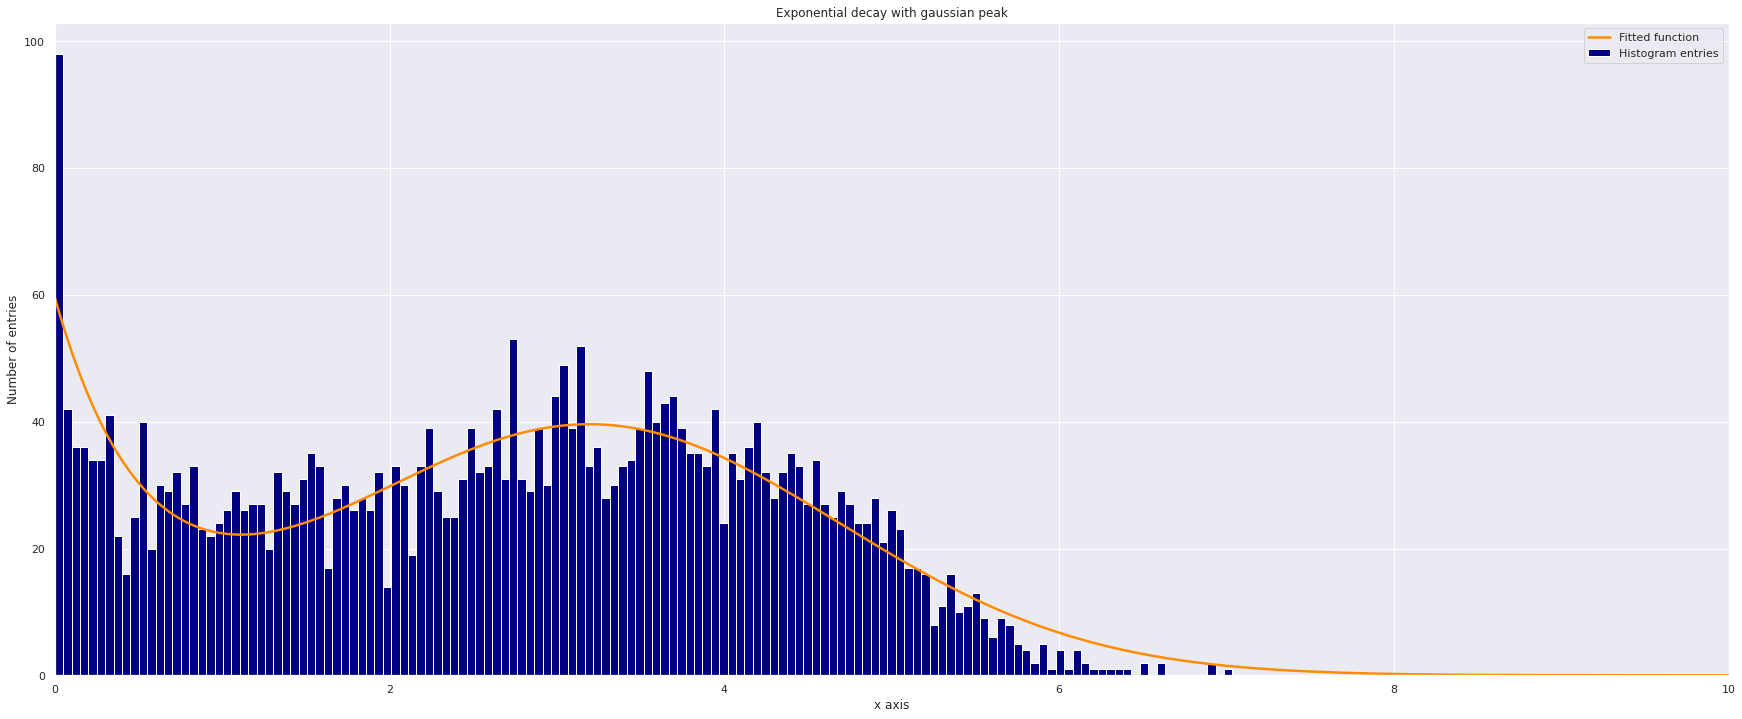

2 12 2019


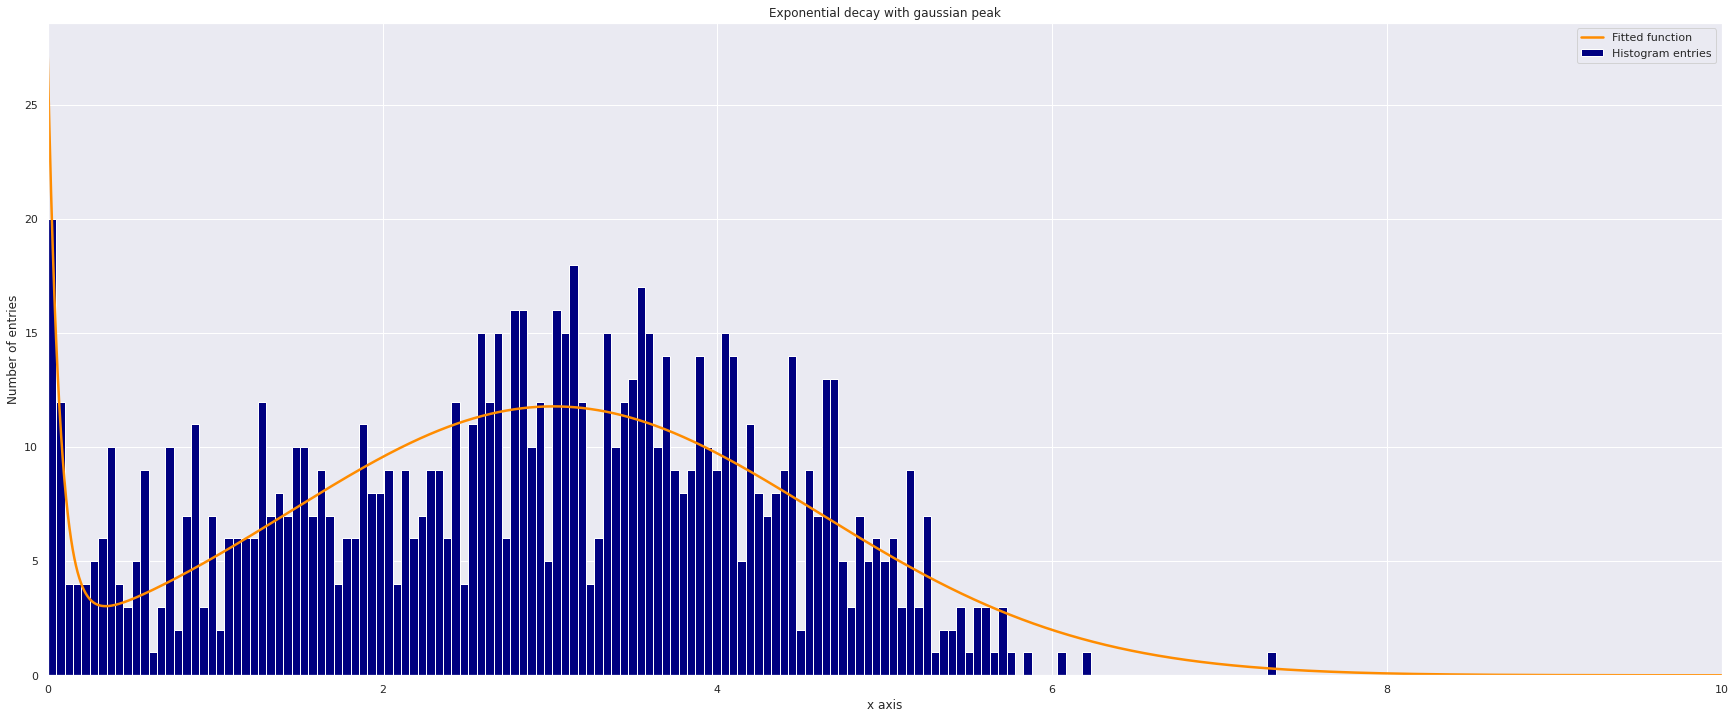

2 4 2020


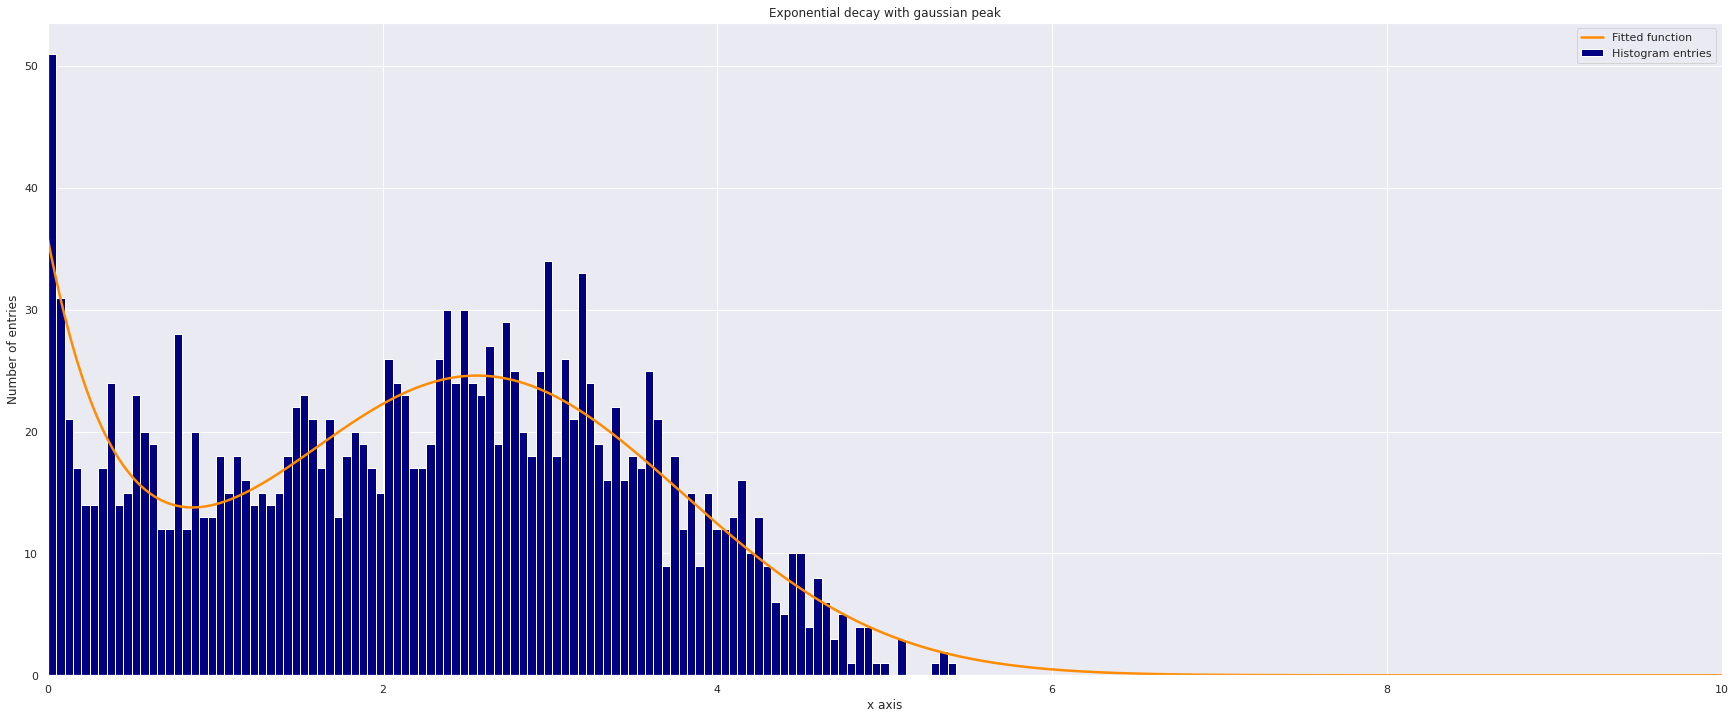

2 10 2020


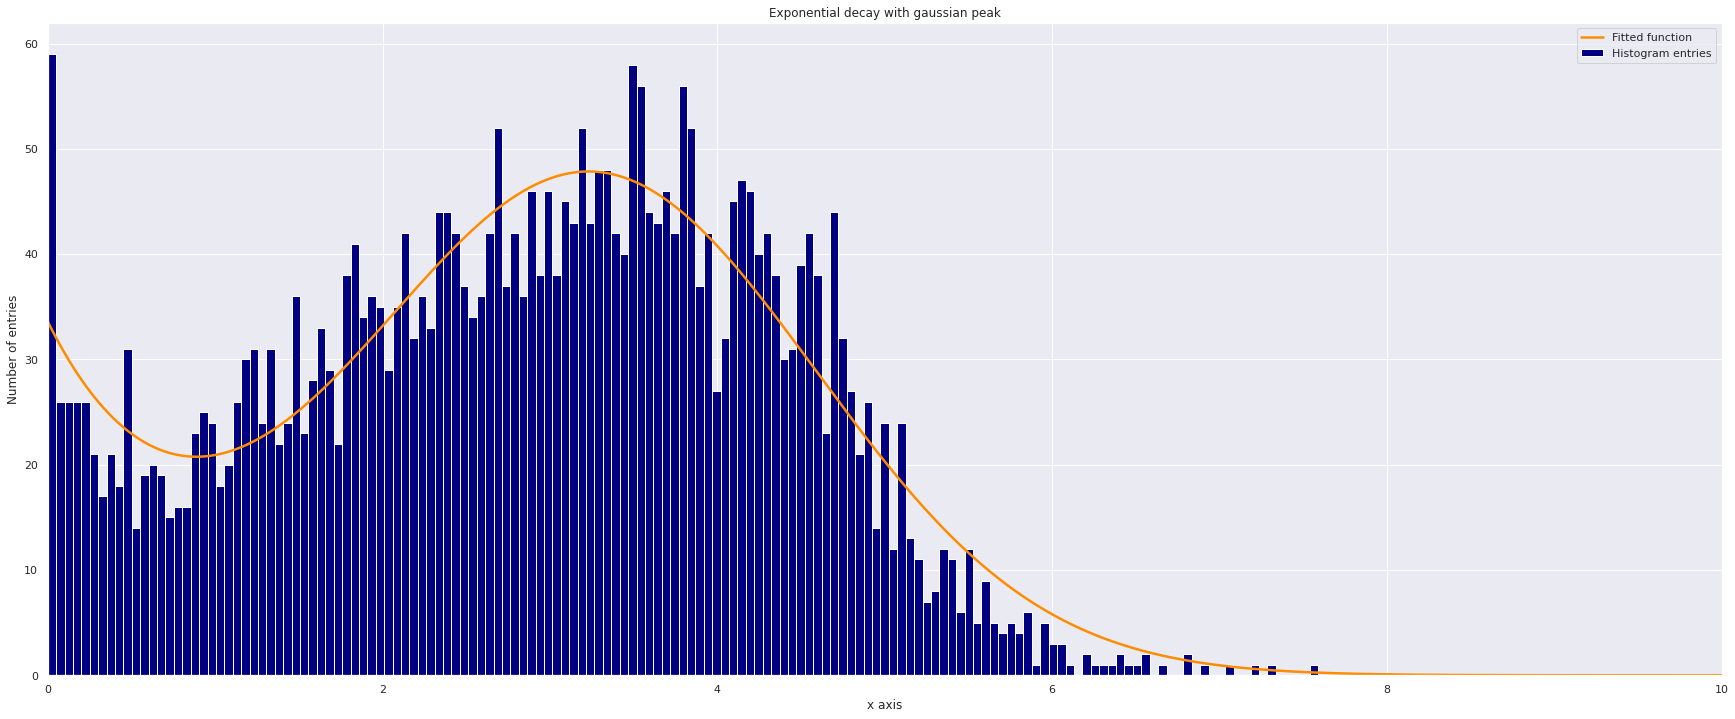

2 11 2020


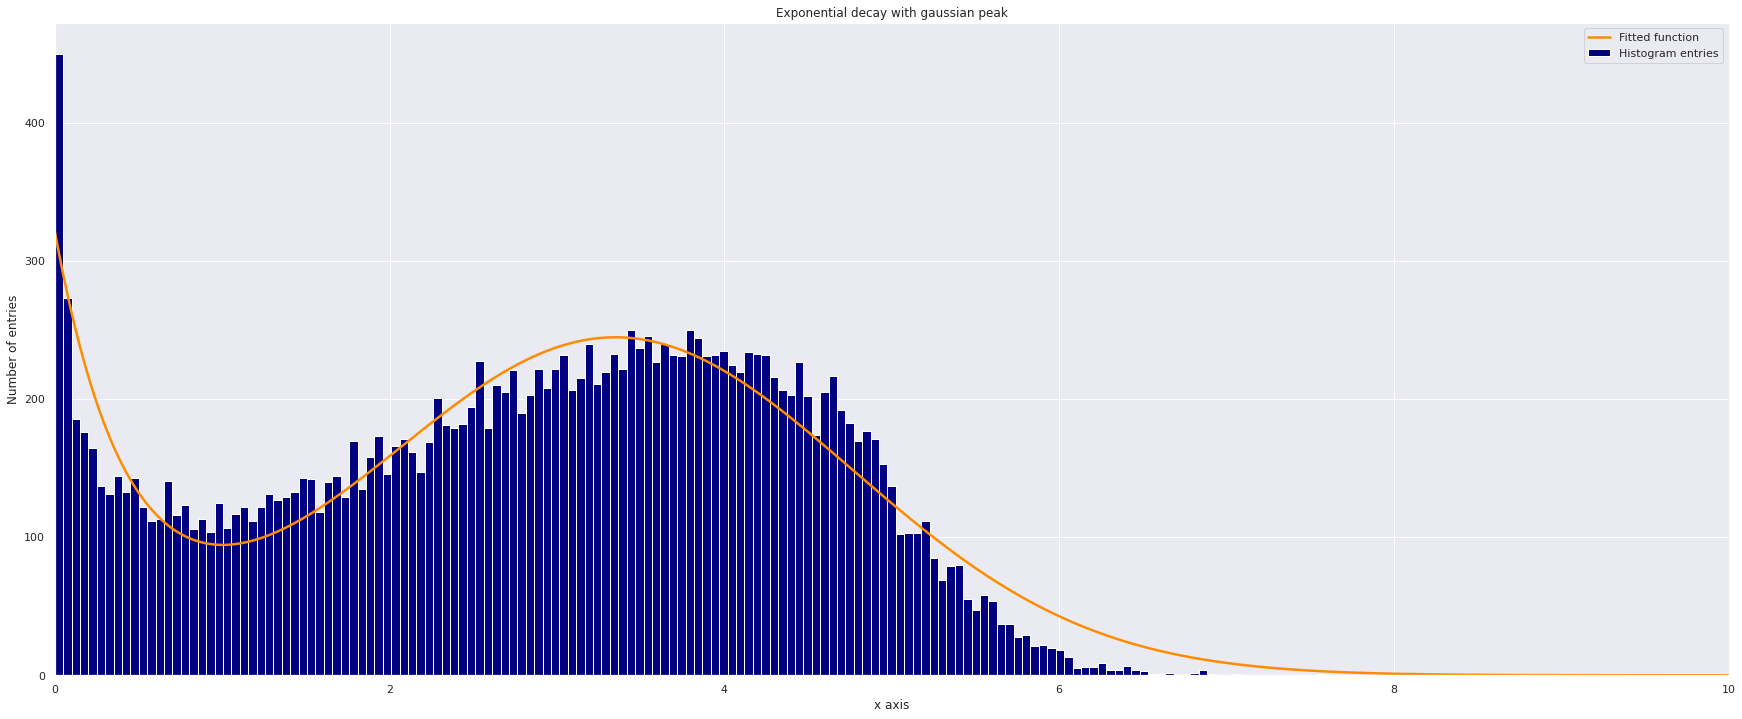

3 12 2019


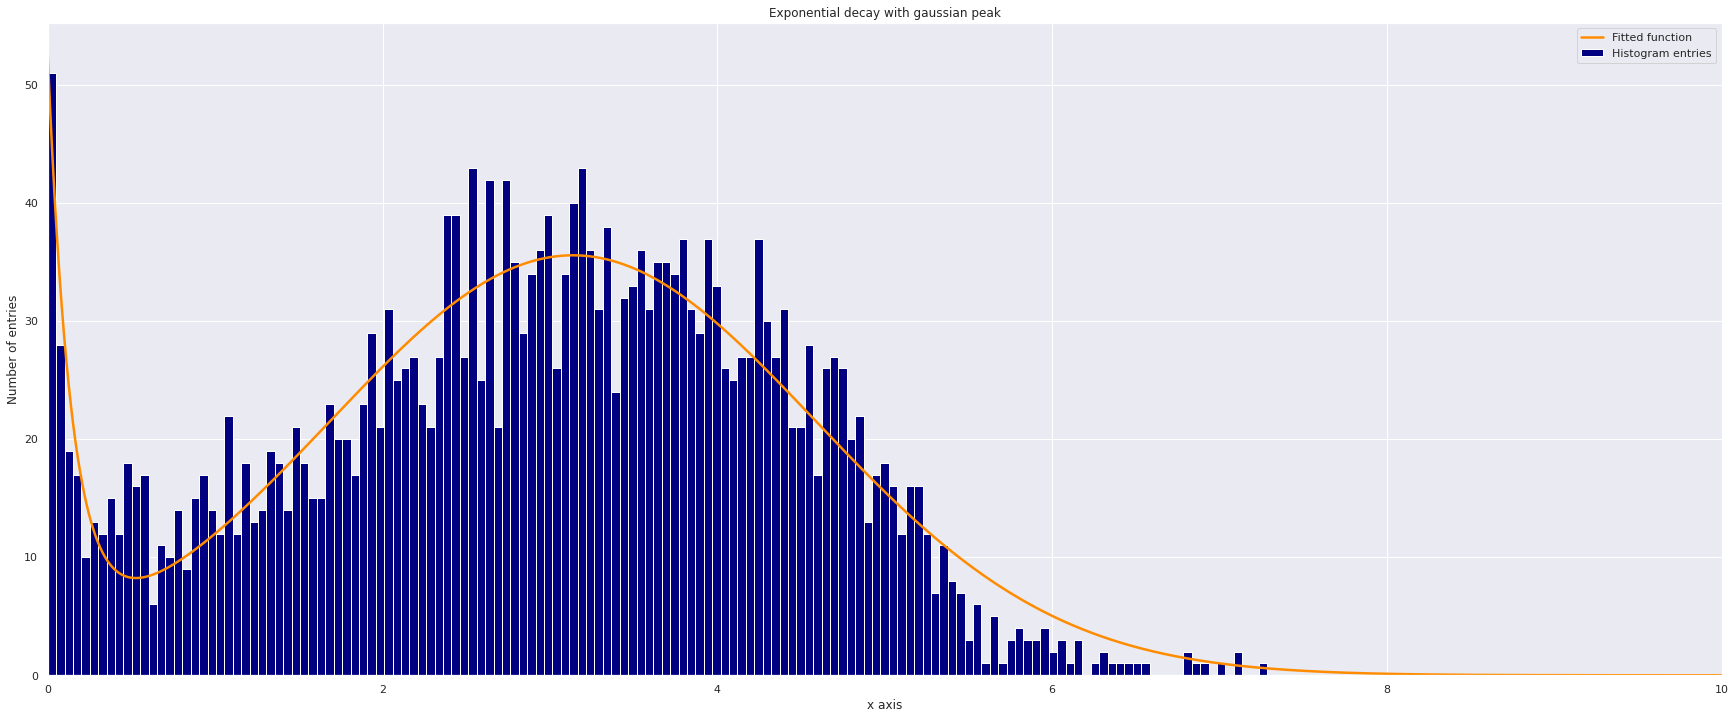

3 11 2020


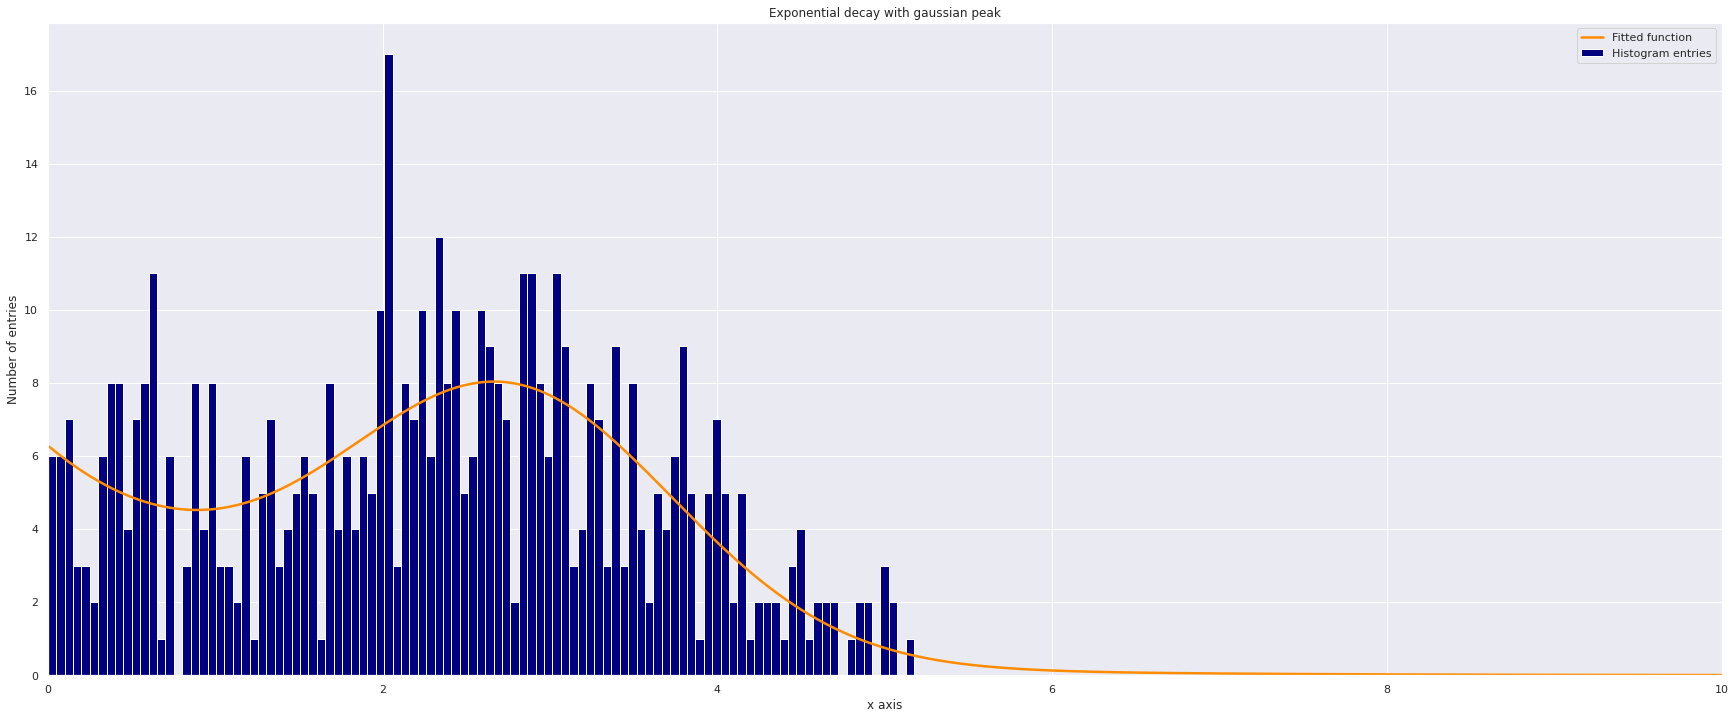

3 3 2022


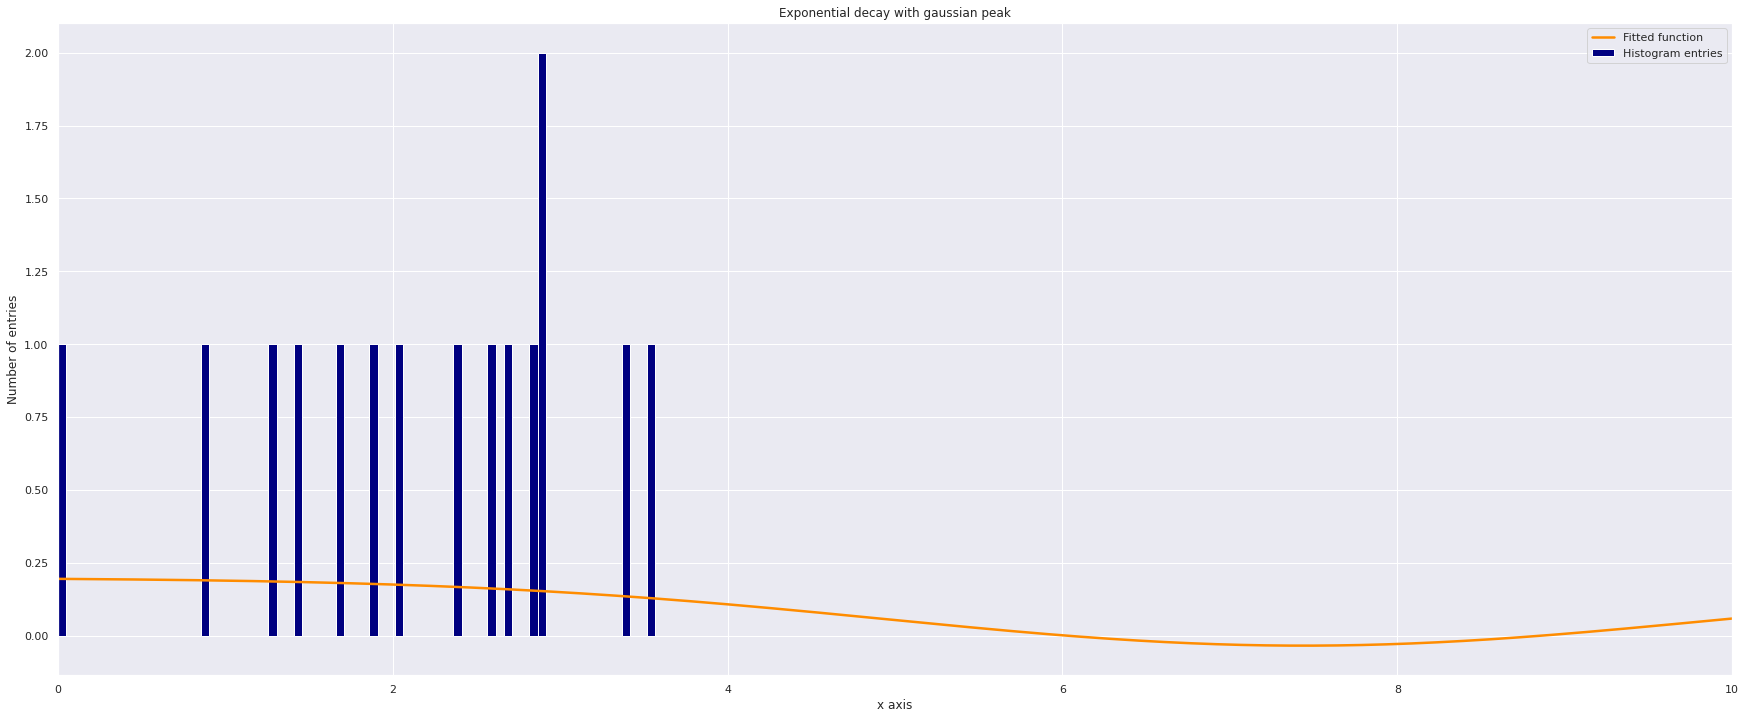

4 10 2019


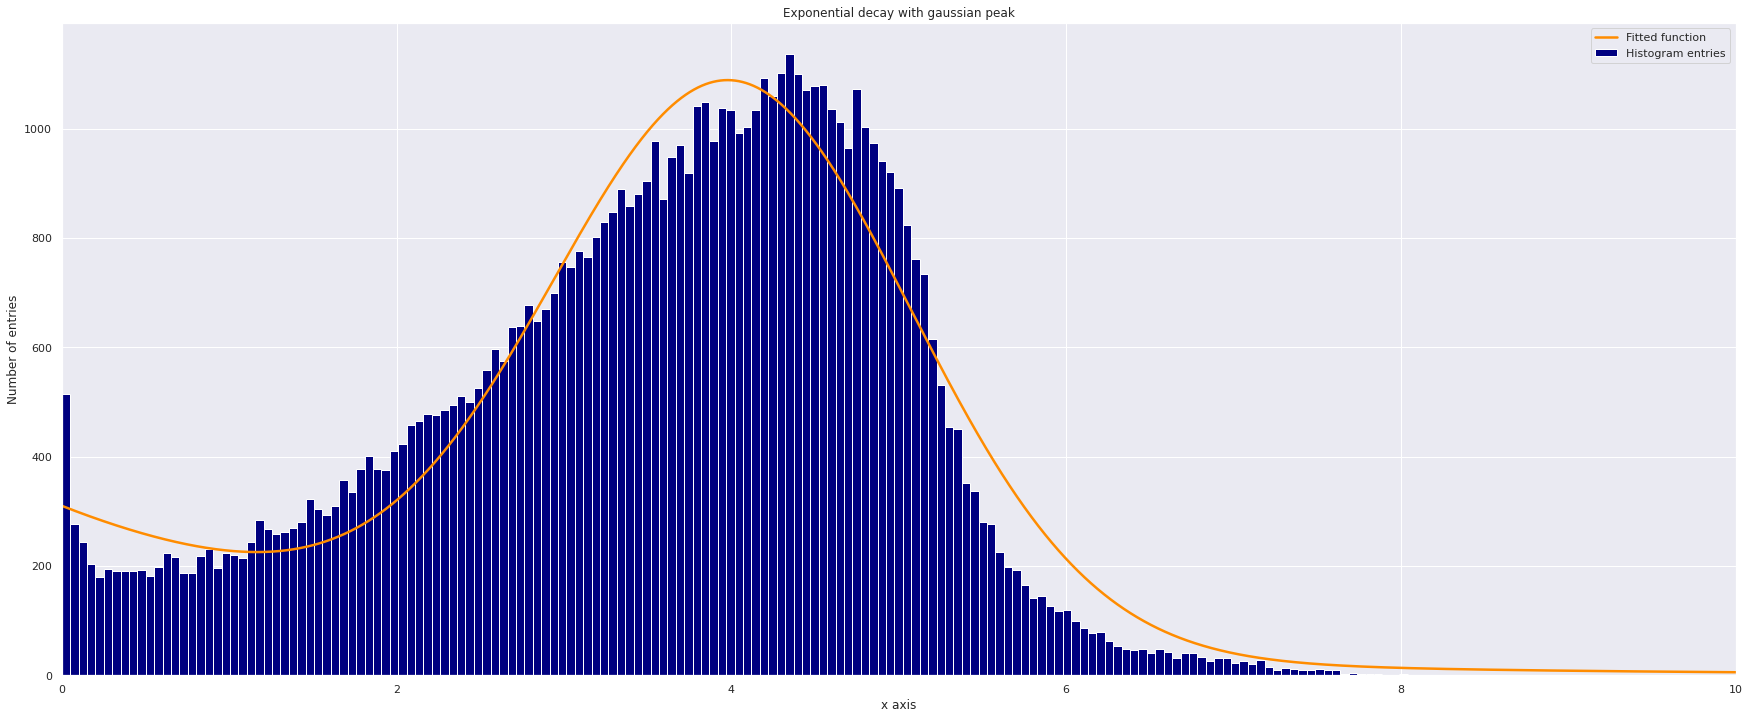

4 12 2019


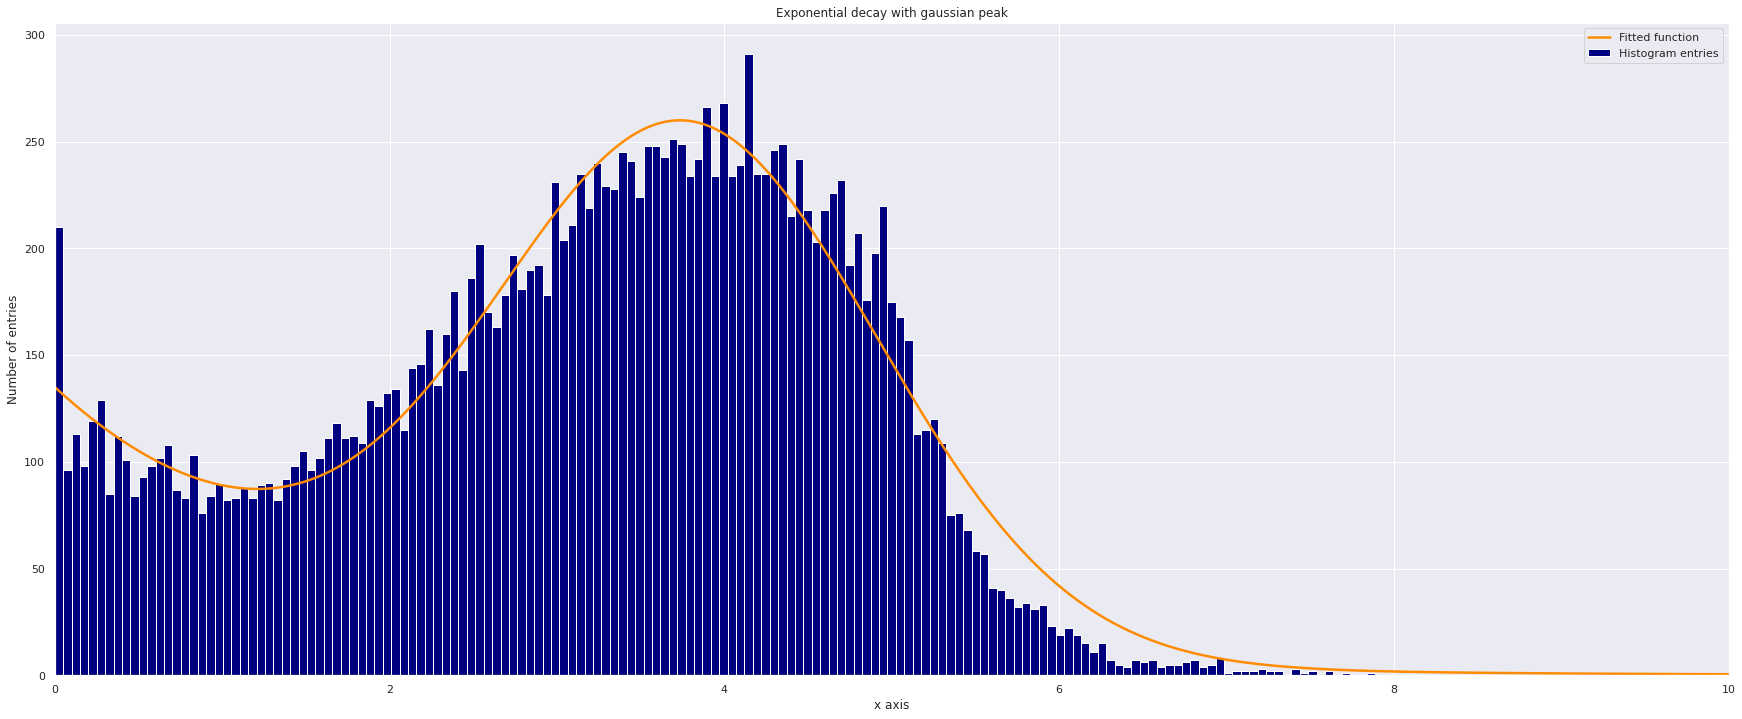

4 4 2020


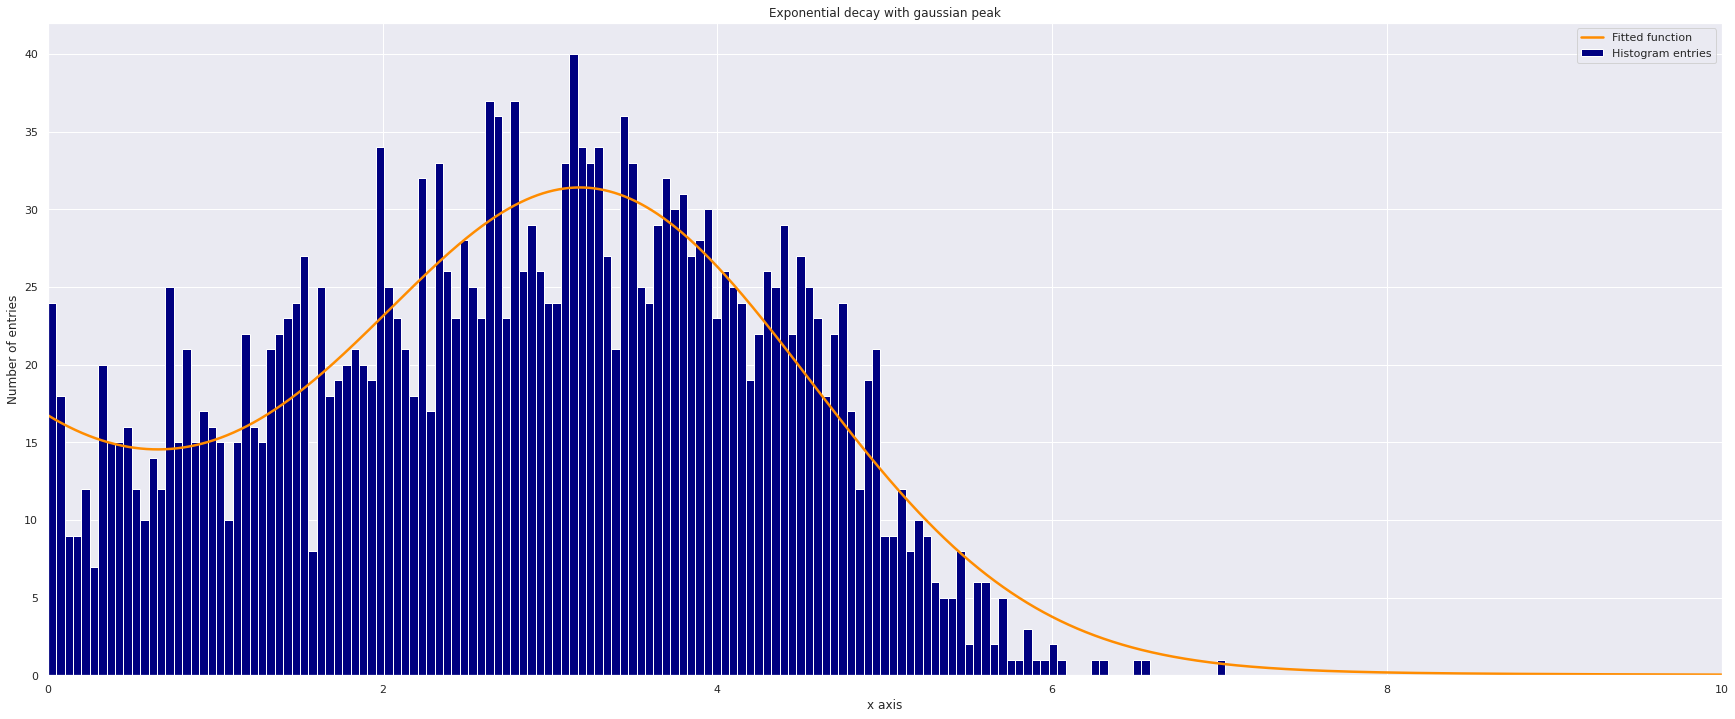

4 4 2021


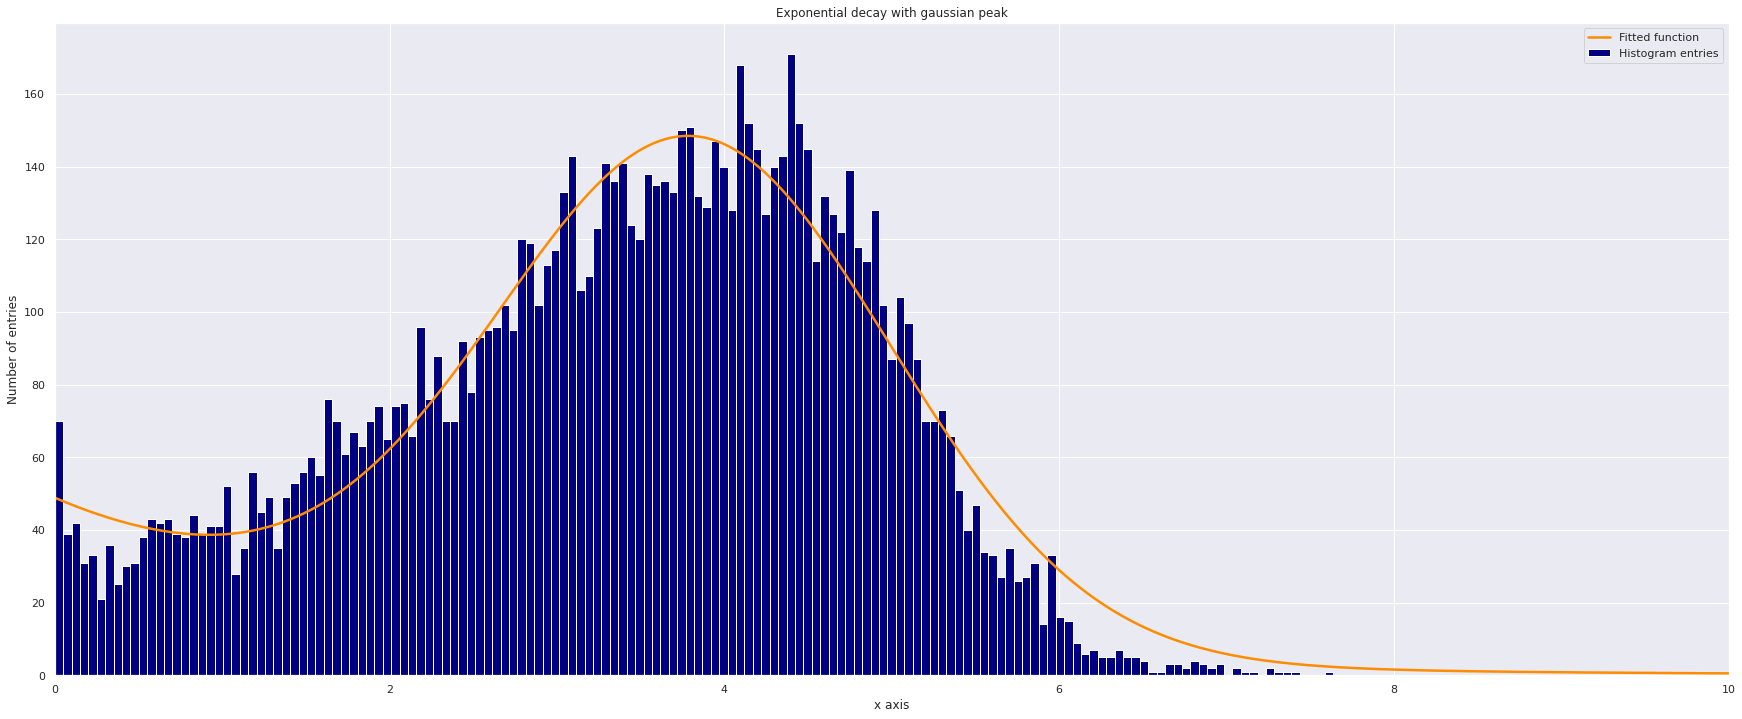

4 6 2022


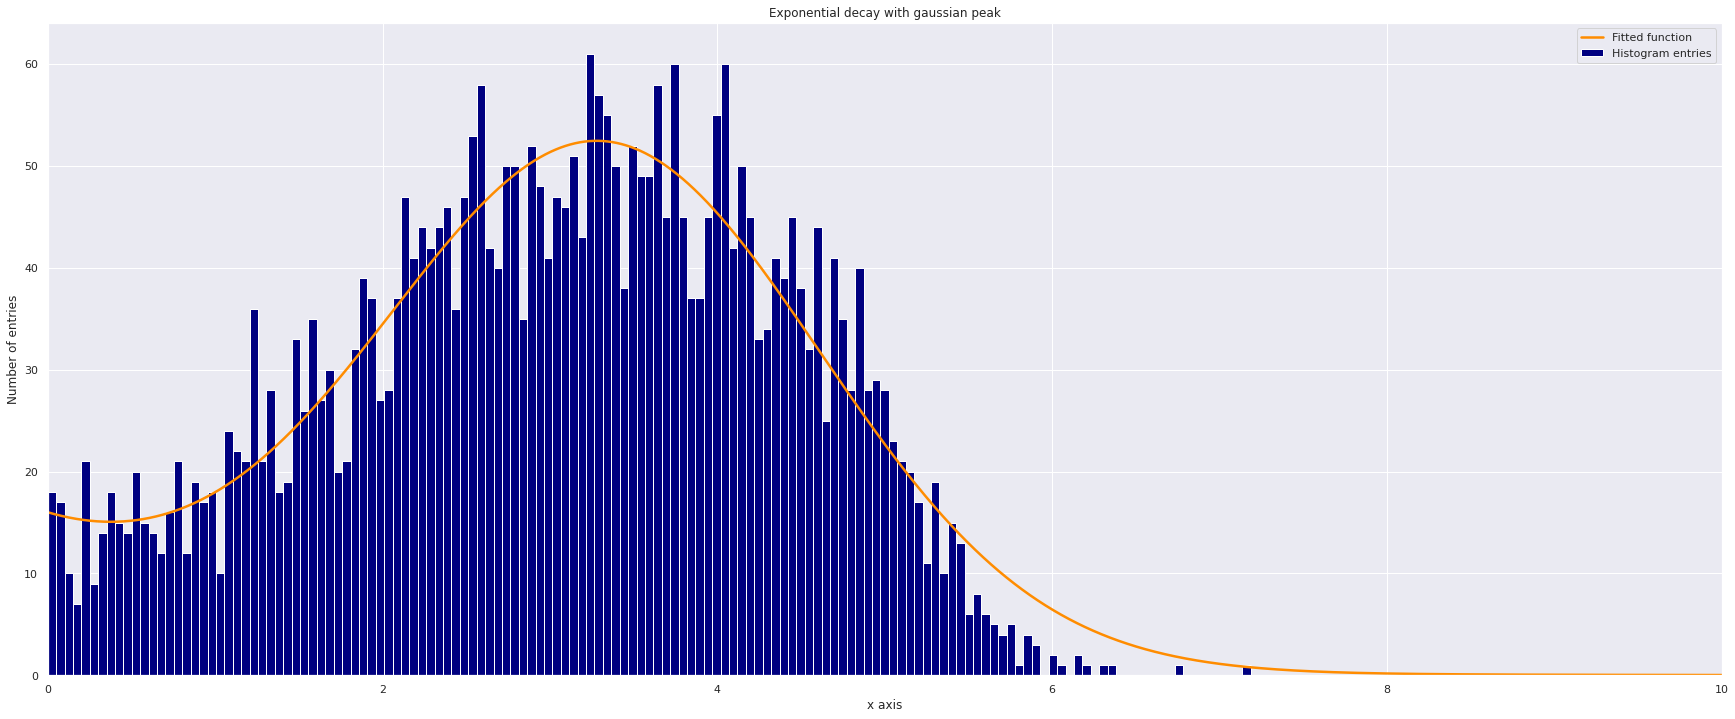

5 11 2019


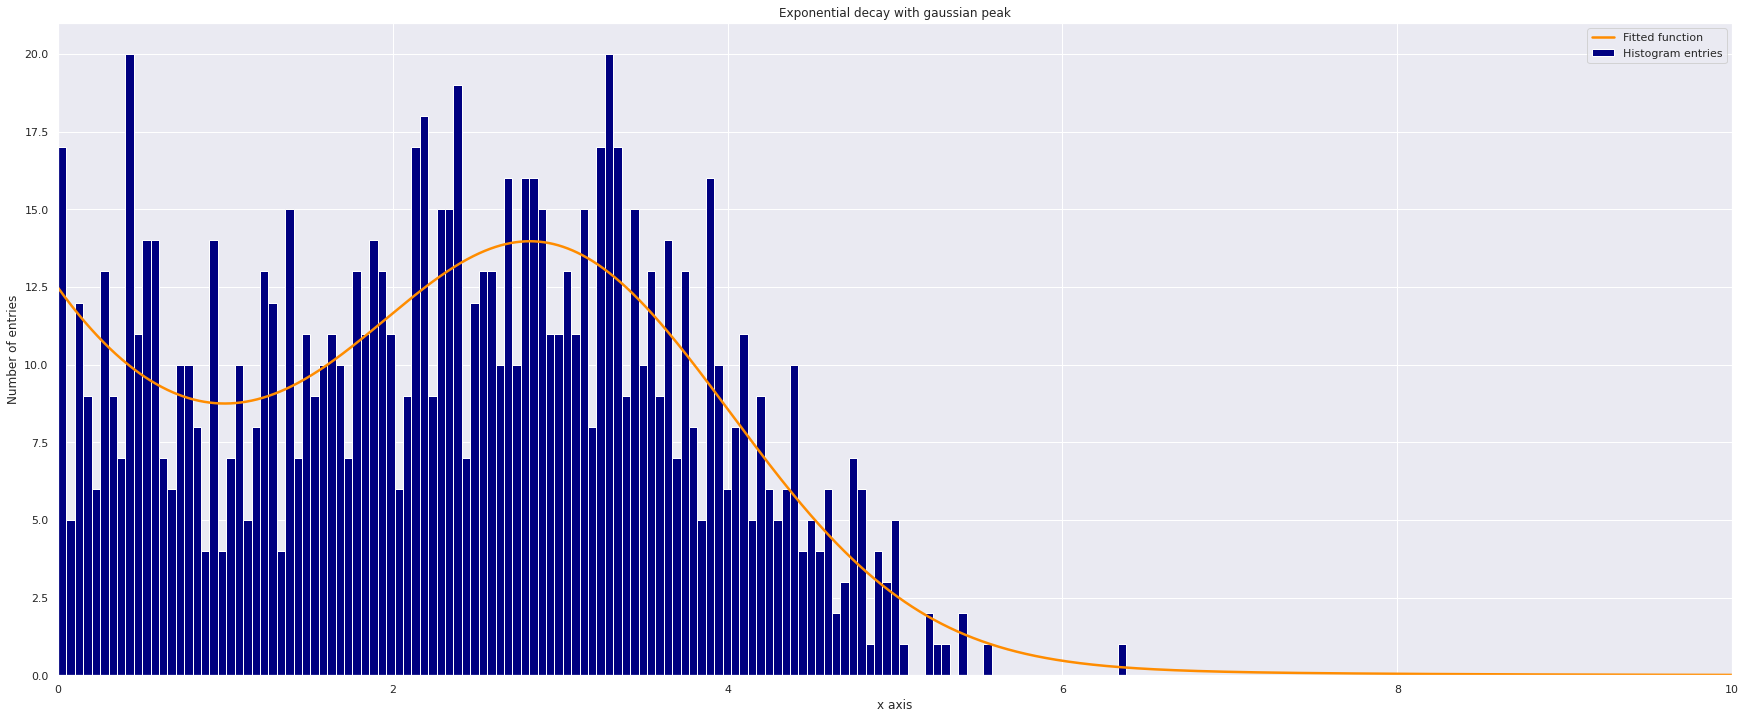

5 3 2020


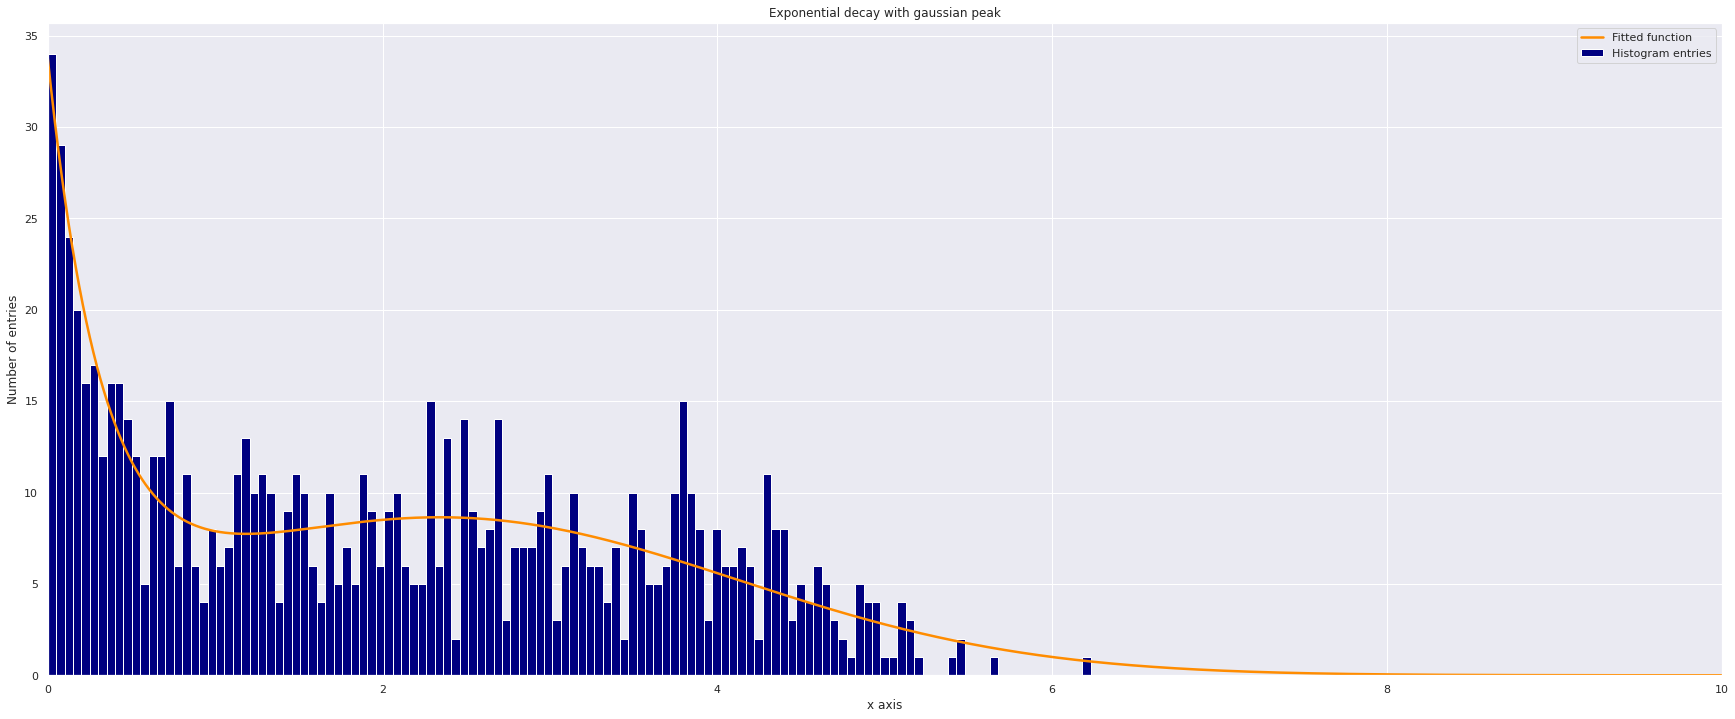

<Figure size 2160x864 with 0 Axes>

In [216]:
for (polygon_id, month, year) in list_of_outliers:
    print(f'{polygon_id} {month} {year}')
    fit_exponential_gaussian_and_plot(footprints, polygon_id, month, year, plot=True)

In [198]:
original_monthly = footprints.groupby(['polygon_id', 'month', 'year']).mean().reset_index()

/tmp/ipykernel_3906316/379240994.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  original_monthly = footprints.groupby(['polygon_id', 'month', 'year']).mean().reset_index()


In [199]:
original_monthly = dfext.add_date_column(original_monthly)

In [ ]:
list_of_outliers = [(1, 10, 2020), (2, 12, 2019), (2, 4, 2019), (2, 4, 2020), (2, 10, 2020), (2, 11, 2020), (3, 3, 2022), (4, 9, 2021), (4, 2, 2022), (5, 11, 2020), (5, 9, 2021), (5, 11, 2021), (5, 2, 2022)]

<AxesSubplot: xlabel='date', ylabel='pai'>

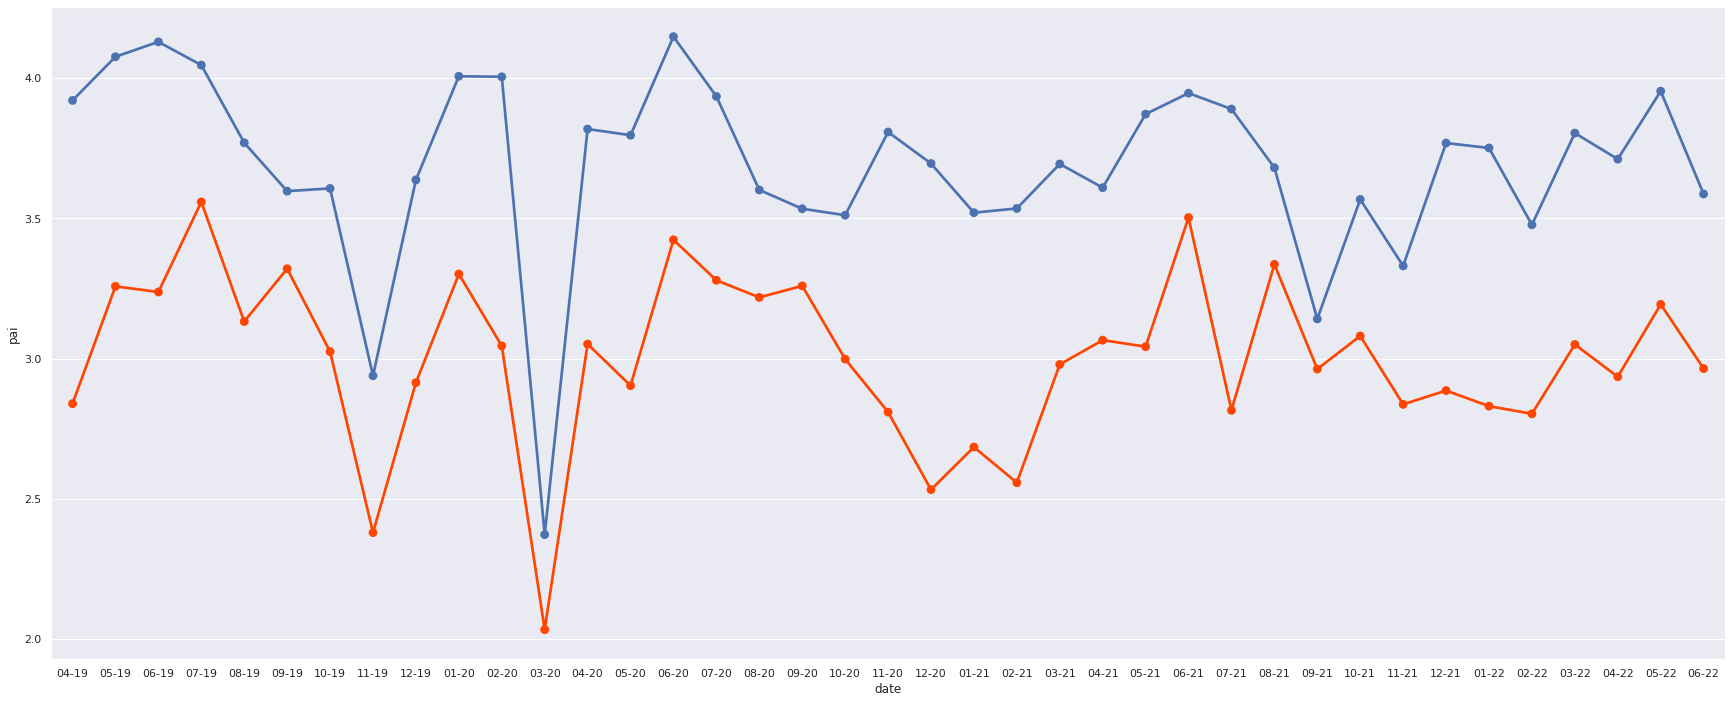

In [212]:
plt.rcParams['figure.figsize'] = [30, 12]
sns.pointplot(monthly[monthly.polygon_id == 5], x='date', y='pai')
sns.pointplot(original_monthly[original_monthly.polygon_id == 5], x='date', y='pai', color='orangered')

Before: 2.606483341383648
After: 2.606483341383648


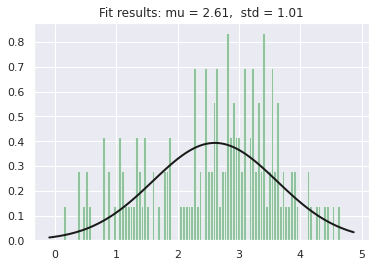

In [186]:
fit_gaussian_and_plot(footprints, 3, 1, 2020)

No data for 1 and 2019
No data for 2 and 2019
No data for 3 and 2019
Before: 2.968226968947101
After: 2.968226968947101


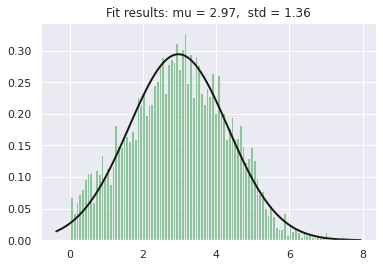

Before: 3.766816629088975
After: 3.766816629088975


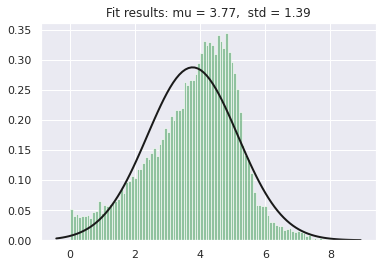

Before: 3.9136493761208238
After: 3.9136493761208238


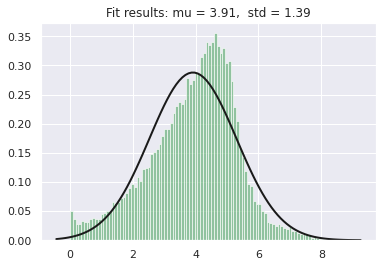

Before: 3.6083985414618502
After: 3.6083985414618502


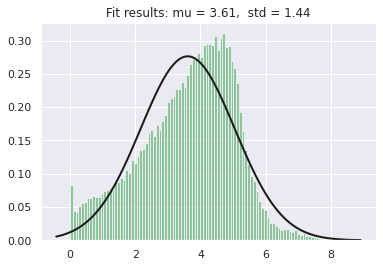

Before: 3.9739635131102196
After: 3.9739635131102196


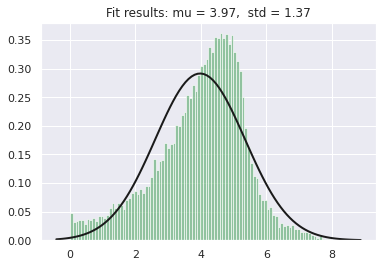

Before: 3.7864092346532976
After: 3.7864092346532976


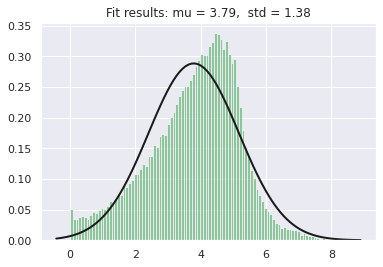

Before: 3.505084014984355
After: 3.505084014984355


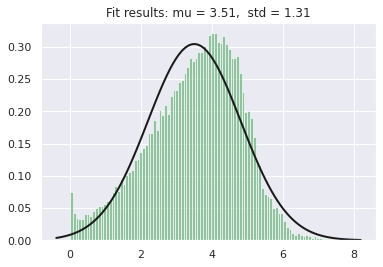

Before: 3.7002674235060105
After: 3.7002674235060105


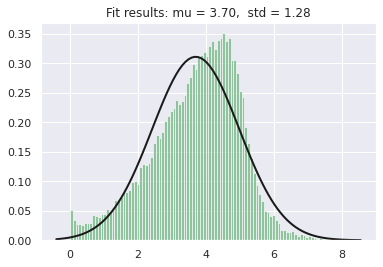

Before: 3.9451326175380212
After: 3.9451326175380212


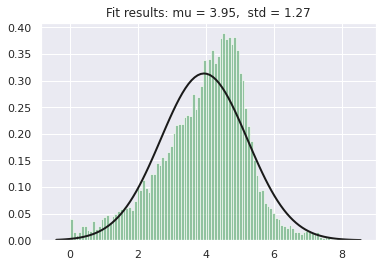

In [124]:
# Plot all months for a given year and a given polygon
year = 2019
for month in range(1, 13):
    fit_gaussian_and_plot(footprints, 1, month, year)

Before: 3.6760165397465676
After: 3.9893629179909214


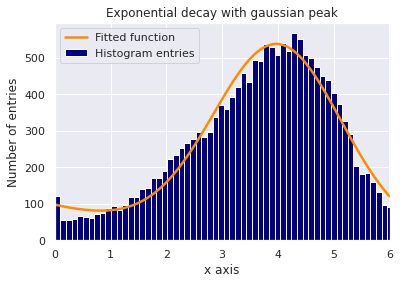

Before: 3.286509583799303
After: 3.4966208406185193


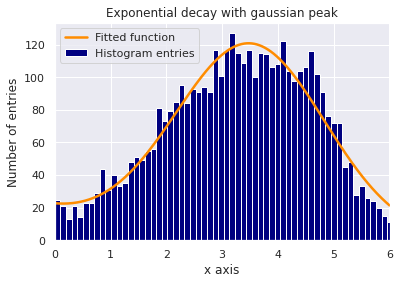

Before: 3.610011912796191
After: 3.898492251035732


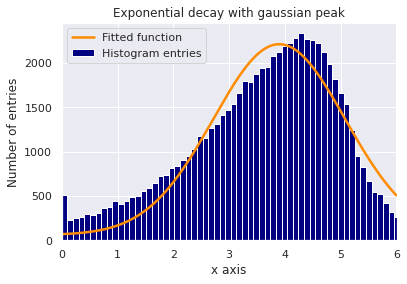

Before: 3.32290833939307
After: 3.484478560637175


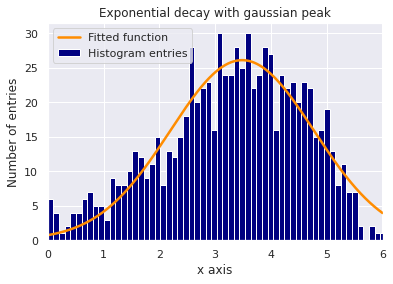

Before: 3.7005750519693685
After: 4.043829919295272


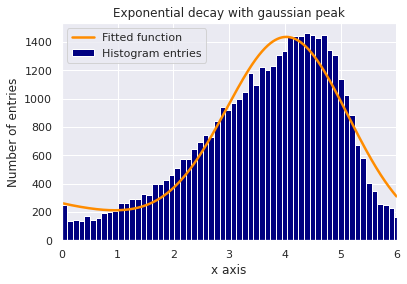

Before: 3.87851603260036
After: 4.189199993564717


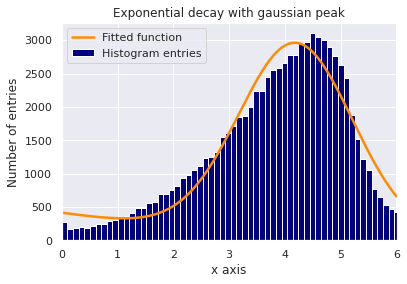

No data for 7 and 2020
Before: 3.011595412835219
After: 3.149424108195003


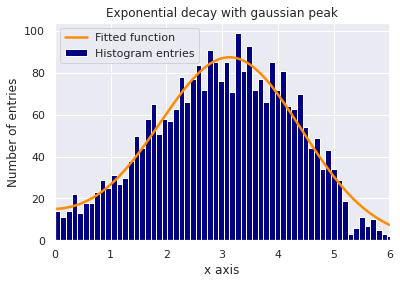

Before: 3.7082079033300537
After: 3.9996171603777855


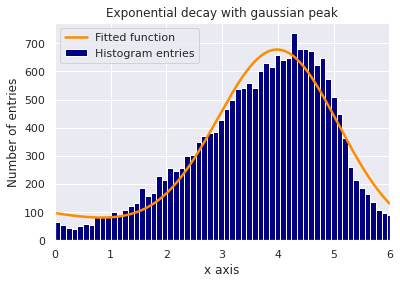

Before: 2.3378650700322146
After: 7.76848544382089


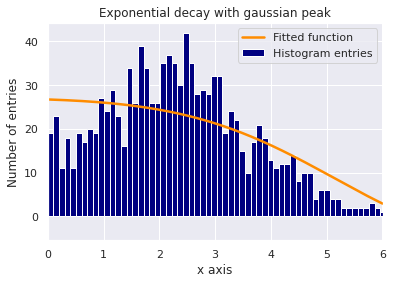

Before: 3.590391941394843
After: 3.922628594616524


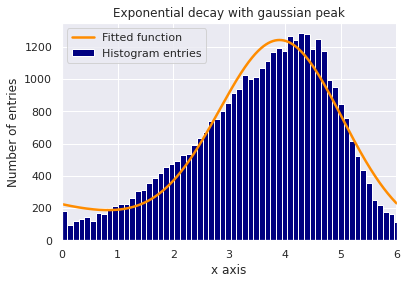

Before: 3.3938926407312517
After: 3.691144398663827


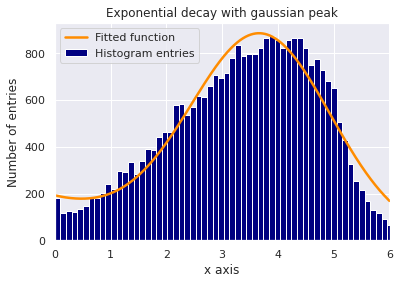

<Figure size 432x288 with 0 Axes>

In [130]:
# Plot all months for a given year and a given polygon
year = 2020
for month in range(1, 13):
    fit_exponential_gaussian_and_plot(footprints, 1, month, year)

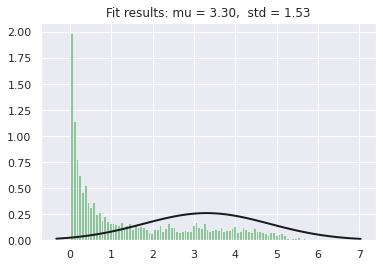

In [80]:
plt.hist(one_month_data.pai, bins=100, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [111]:
one_month_data.shape[0]

3971

### Plot Individual months

In [93]:
def plot_one_month_data(df, polygon_id, month, year, x_lim_max=6):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Footprints for polygon {polygon_id}. Date: {month}-{year}', fontsize=20)
    one_month_data = df.loc[(df.polygon_id == polygon_id)&(df.month==month)&(df.year==year)]
    sns.scatterplot(x=one_month_data.lon_lowestmode, y=one_month_data.lat_lowestmode, ax=ax[0])
    sns.histplot(one_month_data.pai, ax=ax[1])
    ax[1].set_xlim(0,x_lim_max)
    #plt.axvline(one_month_data.pai.mean(), c='red', ls='-', lw=2.5)
    #plt.axvline(one_month_data.pai.median(), c='orange', ls='--', lw=2.5)
    plt.show()
    return one_month_data

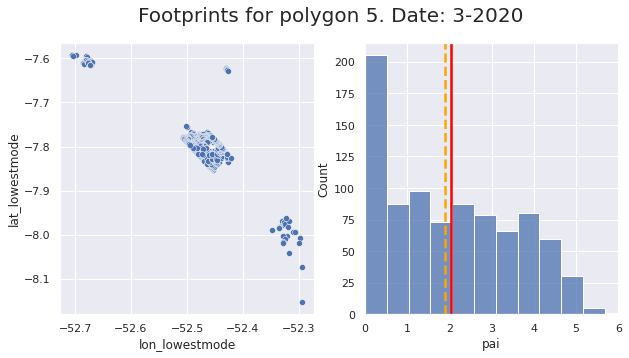

In [4]:
data = plot_one_month_data(footprints, 5, 3, 2020)

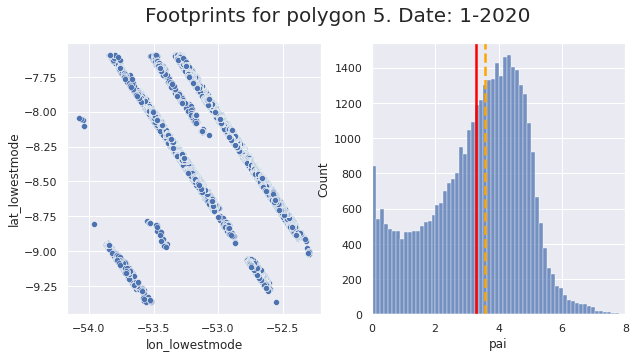

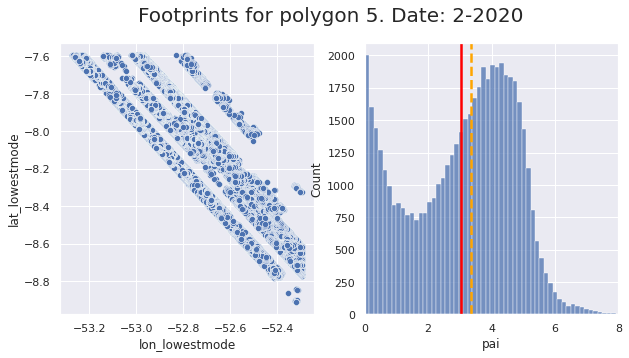

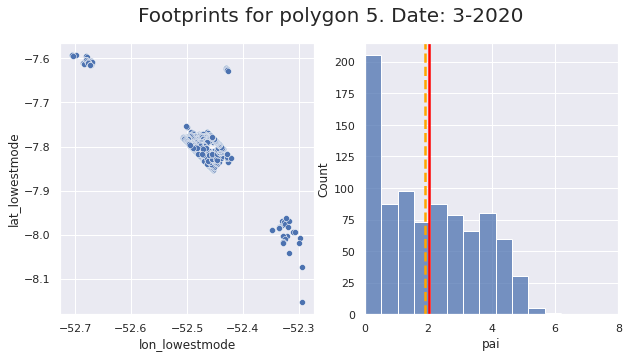

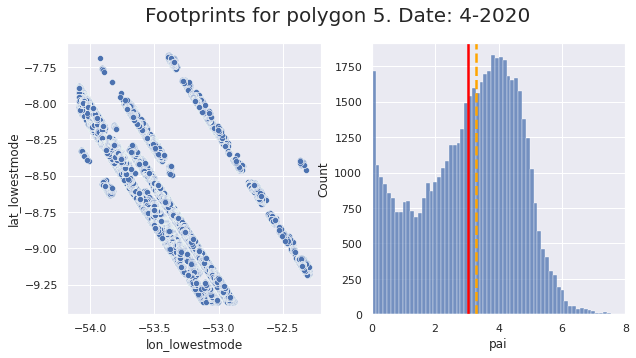

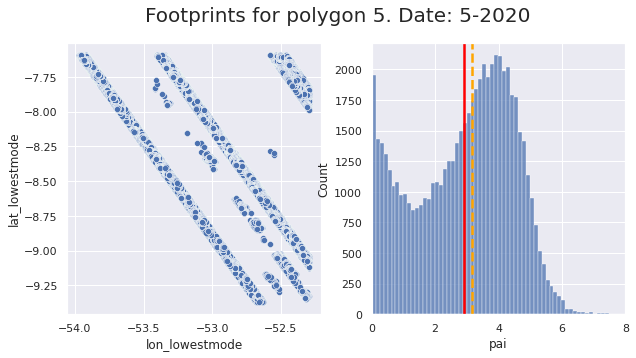

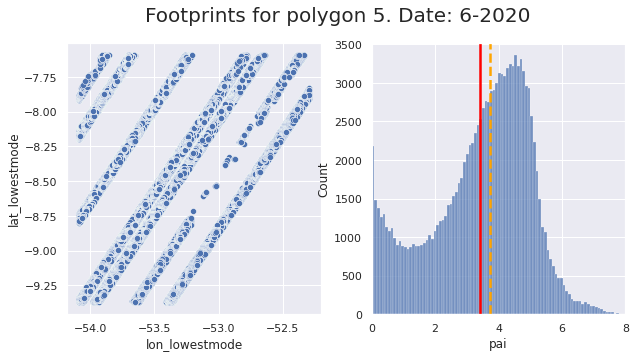

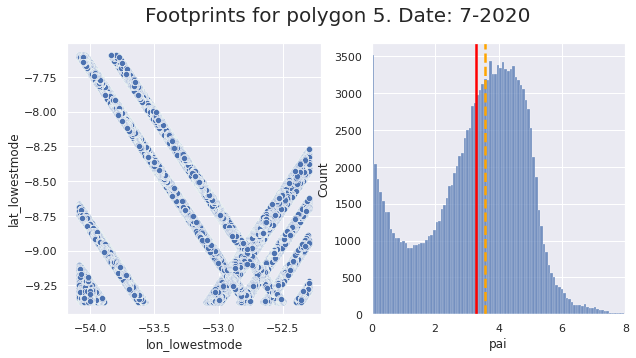

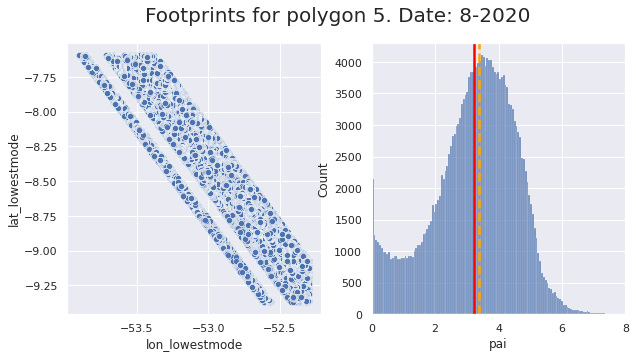

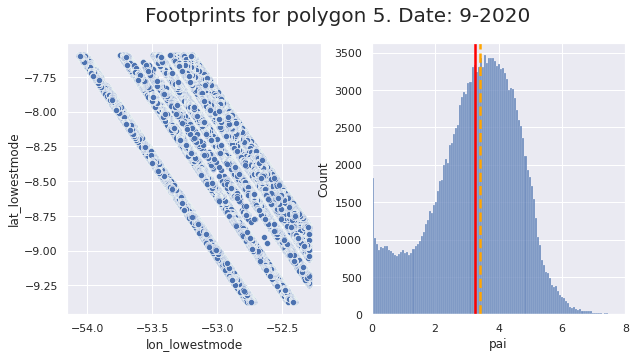

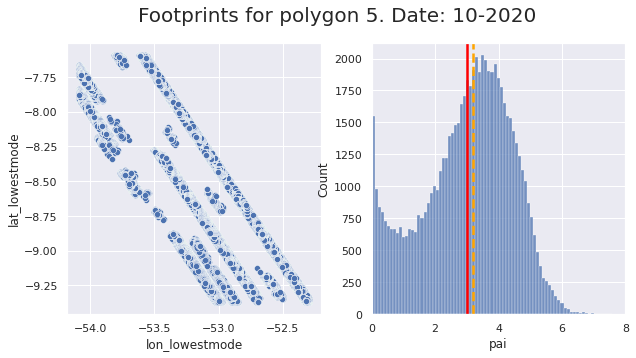

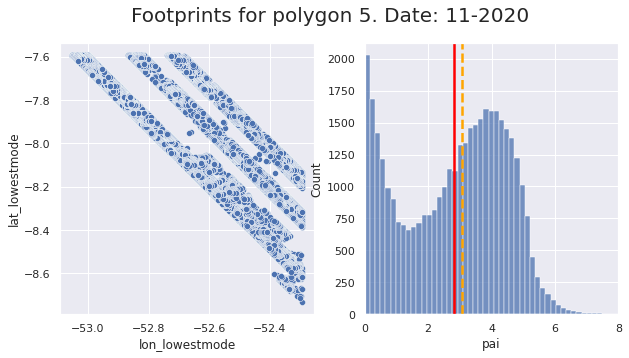

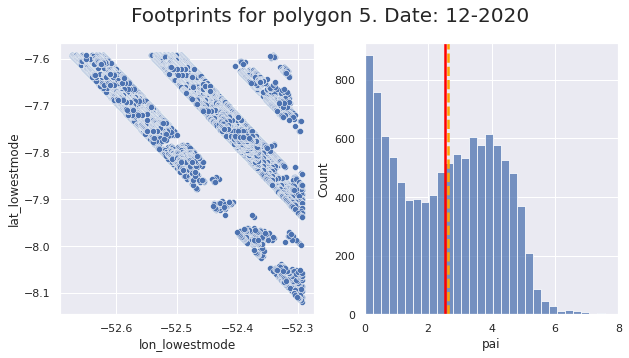

In [10]:
# Plot all months for a given year and a given polygon
year = 2020
for month in range(1, 13):
    plot_one_month_data(footprints, 5, month, year, x_lim_max=8)

## Compare GEDI shots filtered with Land Use filter vs. minimally filtered 

In [11]:
PATH_TO_FILTERED_GEDI = '/maps/drought-with-gedi/gedi_data/gedi_shots_level_2b_land_filtered.csv'
filtered_footprints = pd.read_csv(PATH_TO_FILTERED_GEDI, index_col=0)

In [13]:
filtered_monthly = get_monthly_means_and_shot_count(filtered_footprints, columns=['pai', 'rh100'])

In [14]:
filtered_monthly = interpolate.fill_timeseries_missing_data(filtered_monthly,
                                                            start_date='04-2019', 
                                                            end_date='07-2022', 
                                                            values_to_fill={'number': 0})

In [15]:
filtered_monthly= dfext.add_date_column(filtered_monthly)

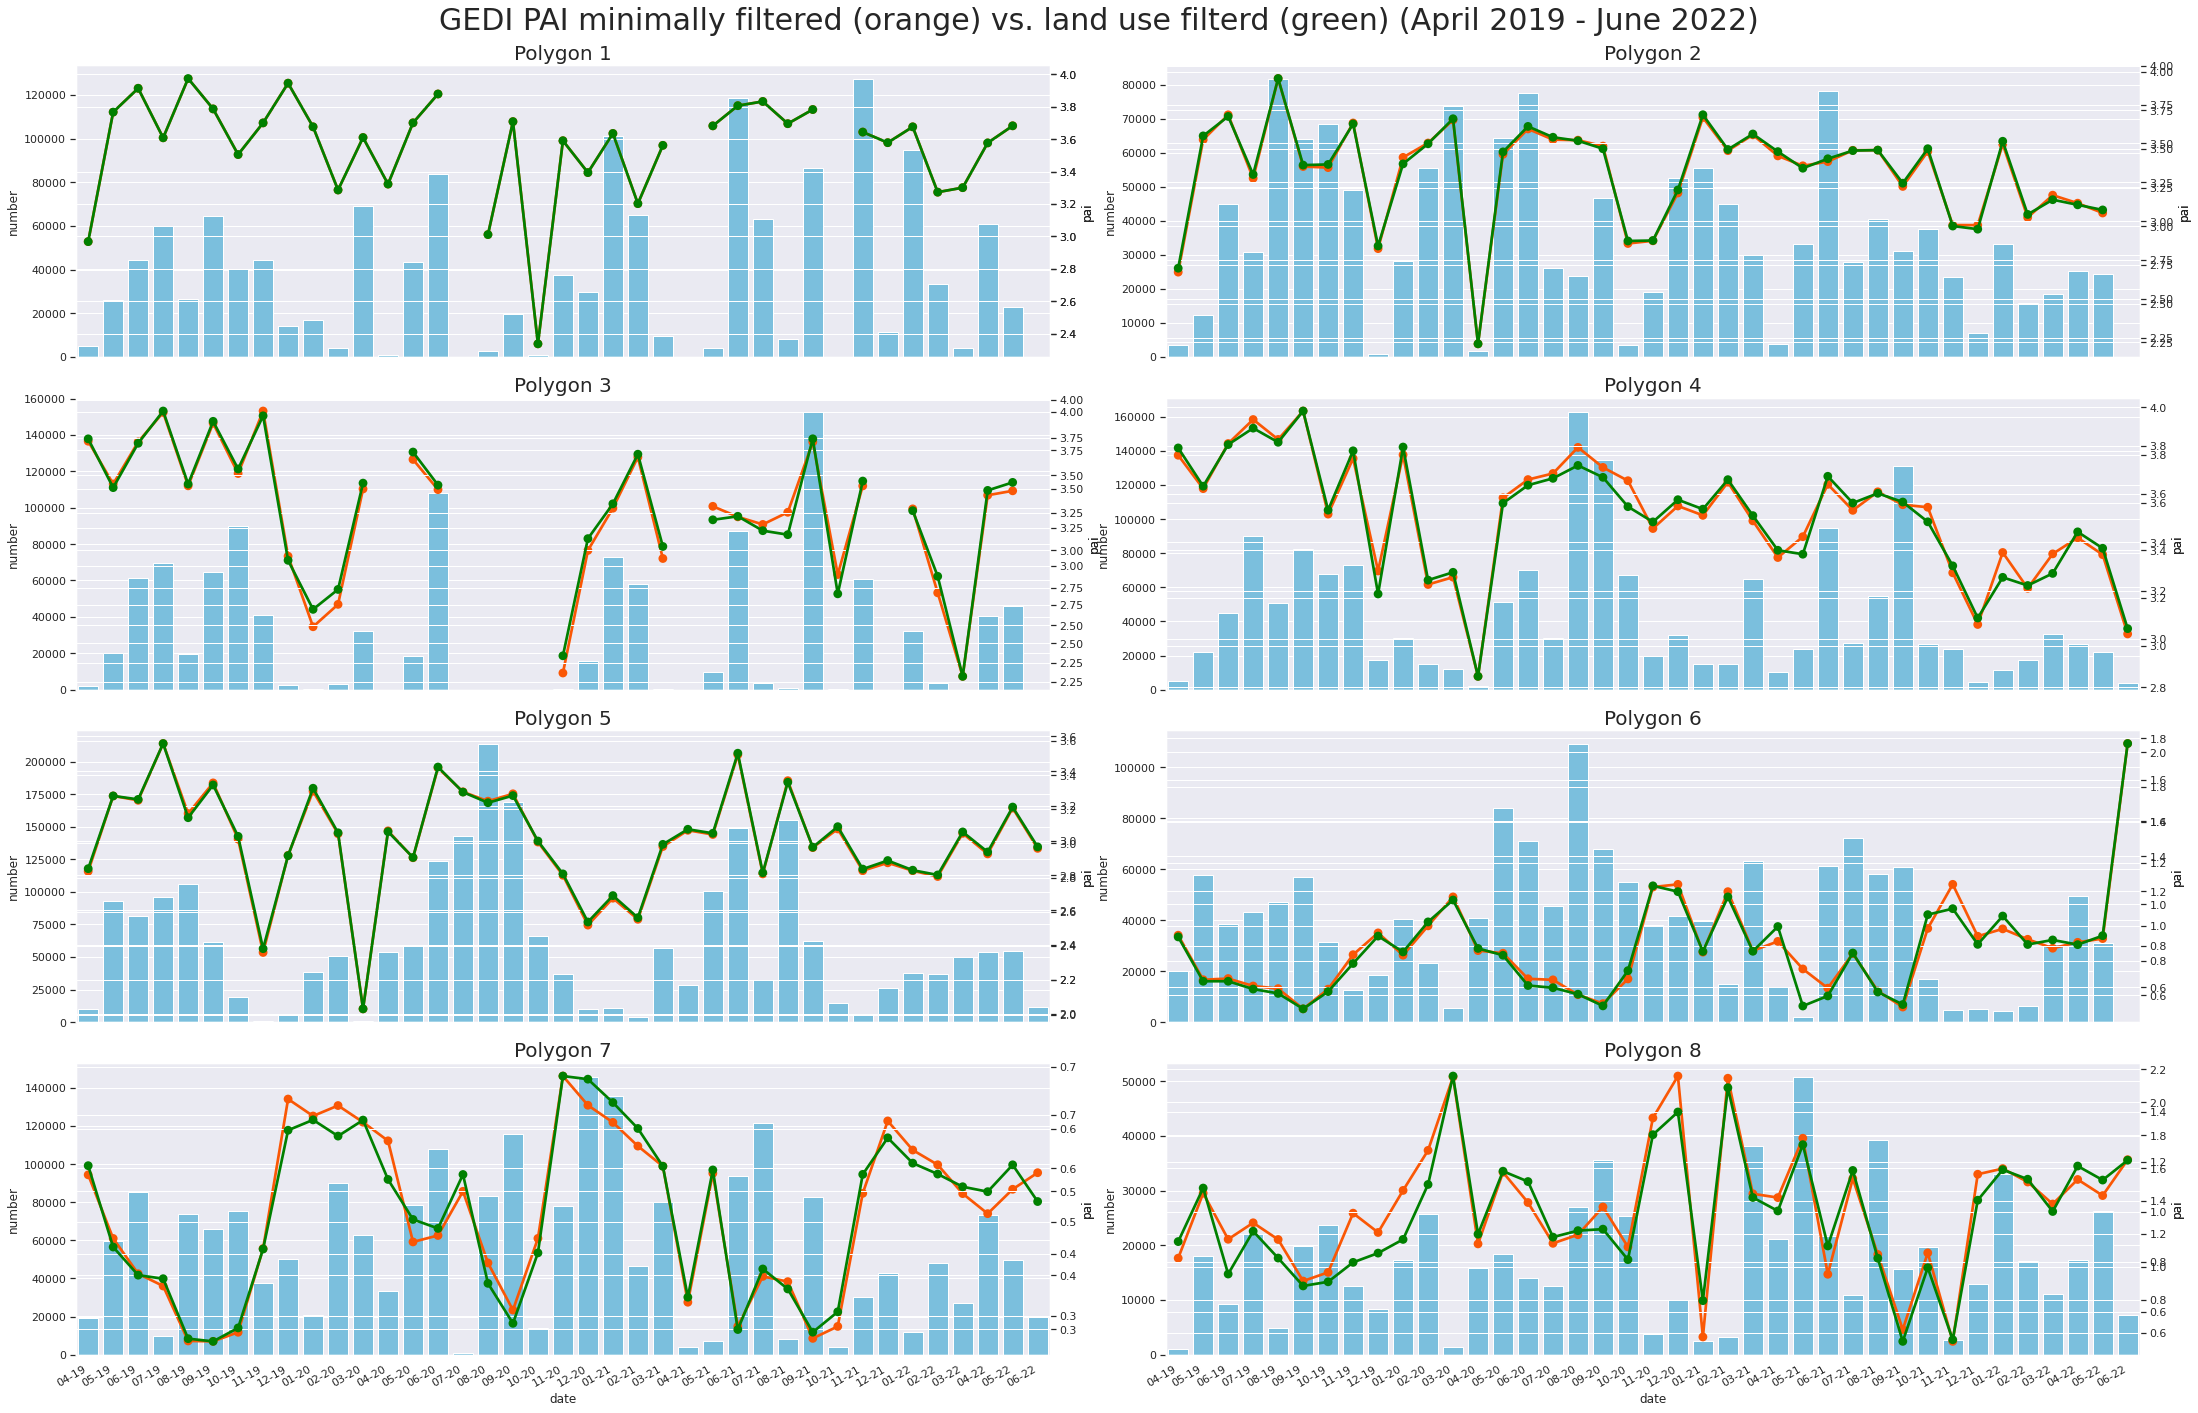

In [16]:
fig, ax = plot.layered_plot_per_polygon(filtered_monthly, 
                                        x='date',
                                        bar_y='number',
                                        line_y='pai',
                                        title="GEDI PAI minimally filtered (orange) vs. land use filterd (green) (April 2019 - June 2022)") # noqa: E501


# Plot PAI on top that wasn't filtered by the land use.
for i in range(8):
    subplot = ax[i // 2, i % 2]

    # Select polygon from the data. Polygon IDs go from 1 to 8.
    polygon_id = i + 1
    polygon_data = monthly[monthly['polygon_id'] == polygon_id]

    # Line plot on top.
    pai_subplot = subplot.twinx()
    sns.pointplot(polygon_data, x='date', y='pai', color='green',
                ax=pai_subplot)
fig.autofmt_xdate()

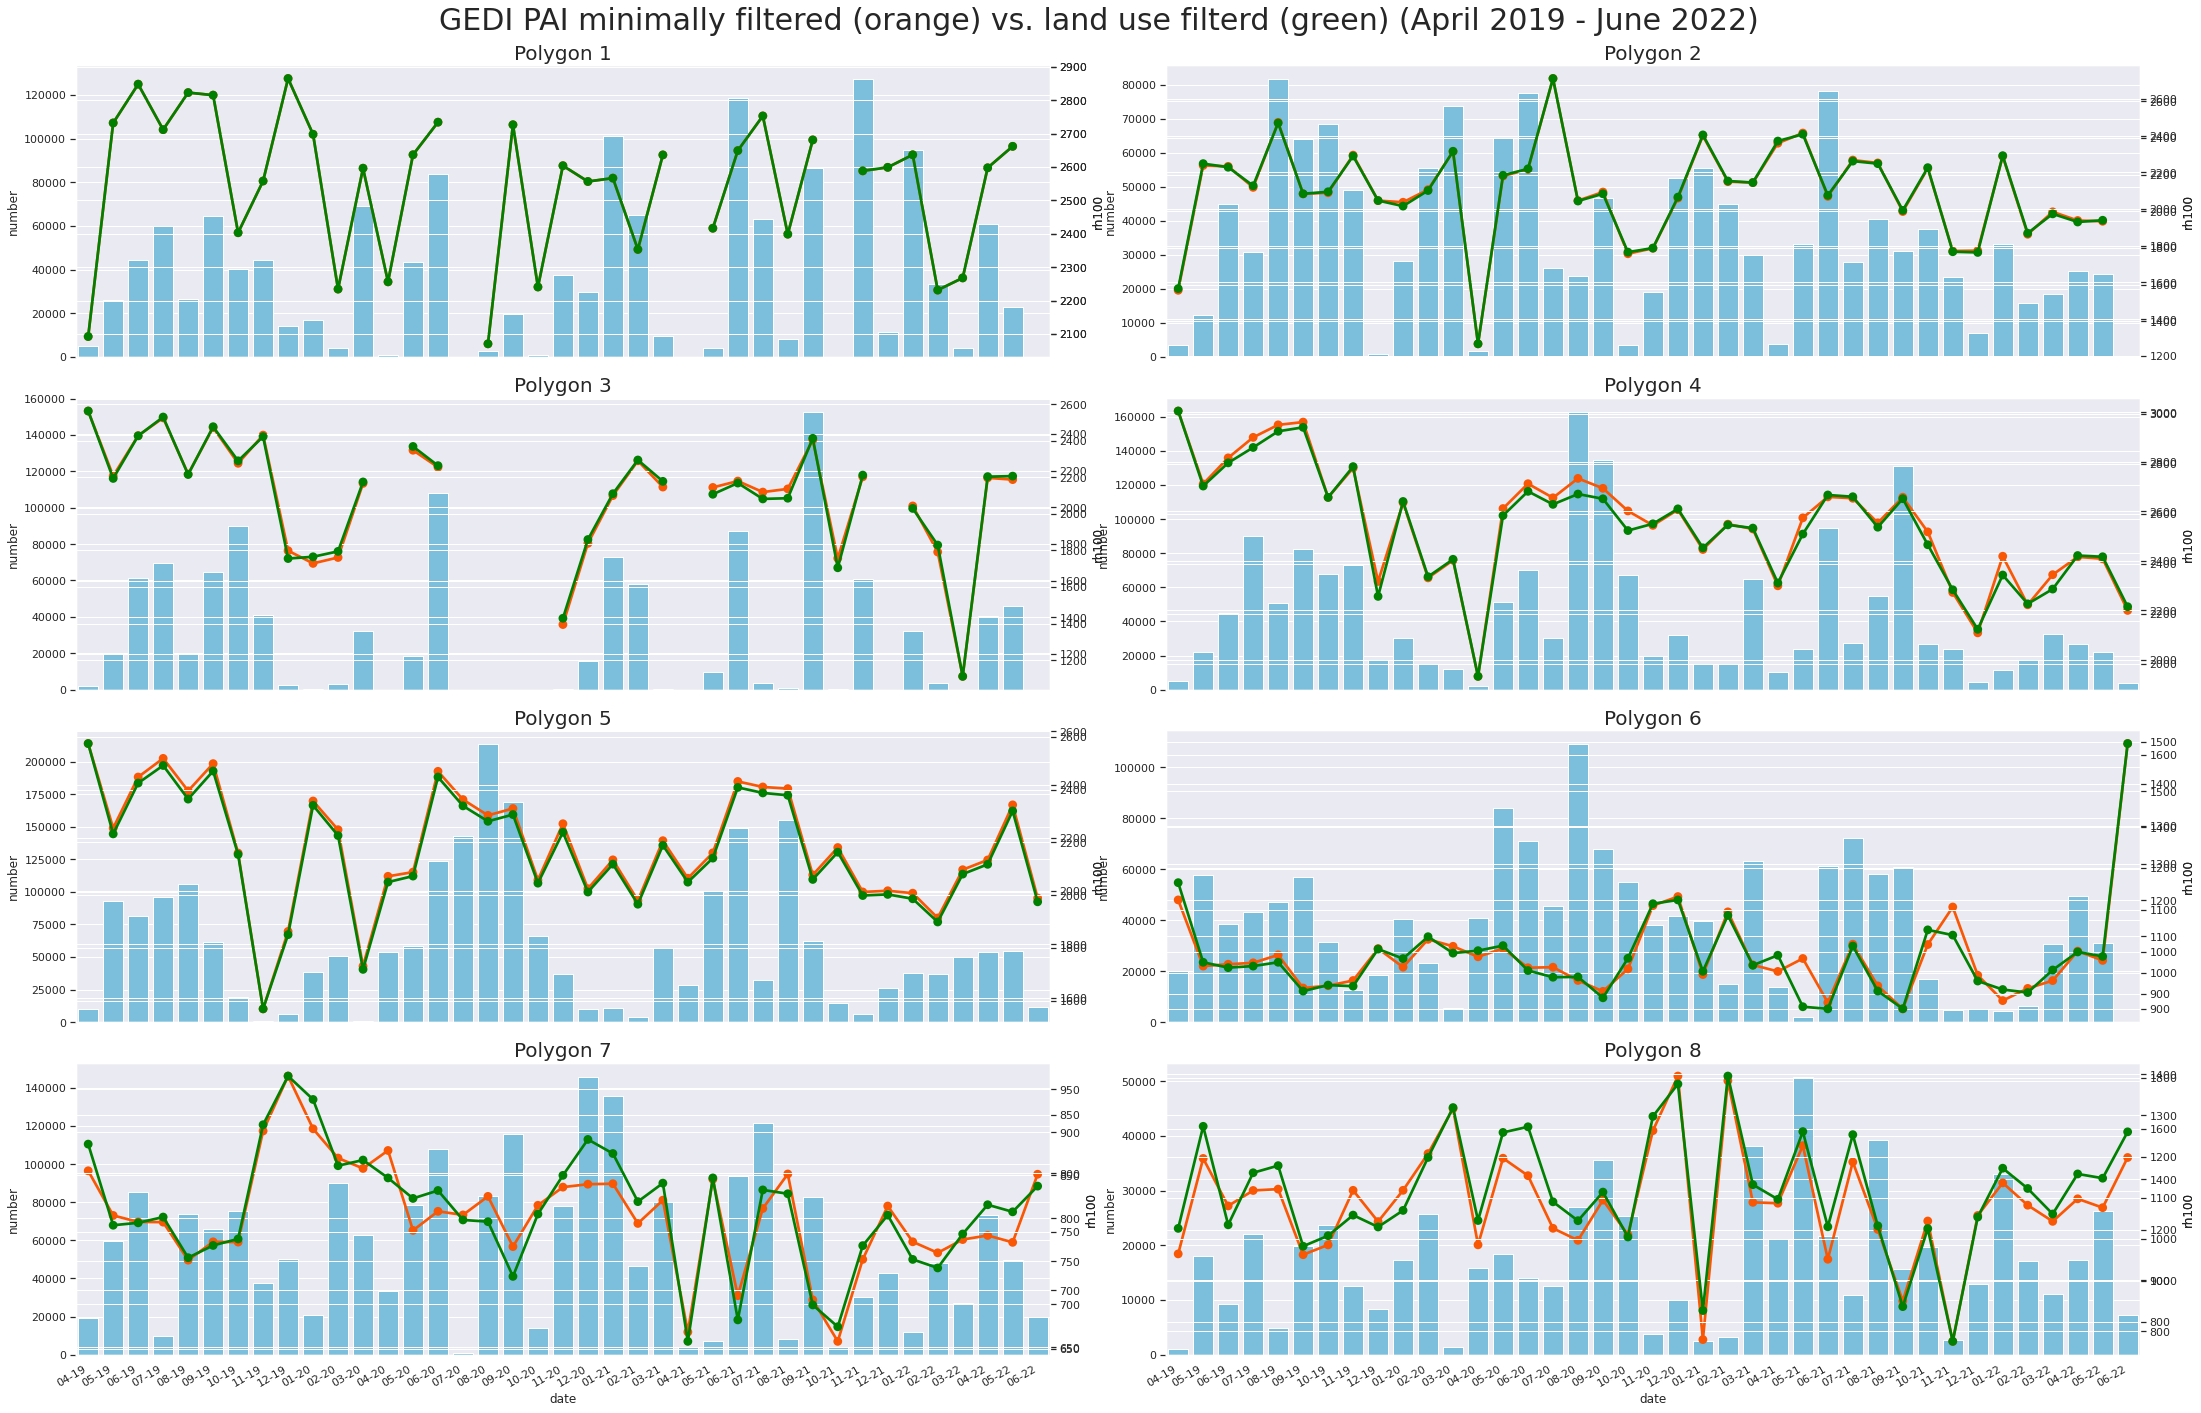

In [17]:
fig, ax = plot.layered_plot_per_polygon(filtered_monthly, 
                                        x='date',
                                        bar_y='number',
                                        line_y='rh100',
                                        title="GEDI PAI minimally filtered (orange) vs. land use filterd (green) (April 2019 - June 2022)") # noqa: E501


# Plot PAI on top that wasn't filtered by the land use.
for i in range(8):
    subplot = ax[i // 2, i % 2]

    # Select polygon from the data. Polygon IDs go from 1 to 8.
    polygon_id = i + 1
    polygon_data = monthly[monthly['polygon_id'] == polygon_id]

    # Line plot on top.
    pai_subplot = subplot.twinx()
    sns.pointplot(polygon_data, x='date', y='rh100', color='green',
                ax=pai_subplot)
fig.autofmt_xdate()